In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [23]:
board_size = 30
device = torch.device('cuda')
batch_size = 64

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
mlp = MLP()
# mlp = torch.load("model")
# mlp.train()
losses = []
train = []
running_loss = 1
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [28]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

In [55]:
while True:
#     dataset, moves, length = game_sim()
    
#     for sample in dataset:
#         rand = int(np.random.rand() * len(train))
#         sample.append(length/900)
#         train.append(sample)
#         if len(train) > 100000:
#             train.remove(train[rand])
    
    batch = torch.zeros(1, 1, 30, 30, device=device)
    labels = torch.zeros(batch_size, 1, device=device)
    
    for i in range(batch_size):
        rand = int(np.random.rand() * len(train))
        sample = train[rand][:len(train[rand]) - 1]
        labels[i] = train[rand][len(train[rand]) - 1:][0]
        board = torch.zeros(board_size, board_size, device=device)
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))
        batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)
        
    batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
    optimizer.zero_grad()
    outputs = mlp(batch) #(length, moves)
    loss = loss_function(outputs, labels)
    running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
    print(running_loss)
    losses.append(running_loss)
    loss.backward()
    optimizer.step()
        


0.0005112689988852376
0.0004975924307256193
0.0005087074230036959
0.0004960740032908462
0.0005050768746242353
0.0004976911860586341
0.0005094616571130129
0.0005107114301714395
0.0005055240067308183
0.0004991629669970306
0.0005192094498229949
0.0005070568373397749
0.0004903165635719831
0.00048030920319862085
0.0004868756951147937
0.0004798745082136652
0.0004721598524054508
0.0004628982685061727
0.0004676541504795046
0.00046307336688817516
0.00046431928809964785
0.0004713074459137839
0.0004518892901029651
0.00046658763316562456
0.00046618666968959436
0.0004654673801579433
0.00048063920289740183
0.0004797421085782965
0.0004623979272255856
0.0004781922855542206
0.0004873184032946321
0.00047860600913419515
0.0004800144620729613
0.0004867531183616633
0.00047357967172992067
0.0005012802039080725
0.0004887946791075273
0.0004960946028826479
0.0005088917935715923
0.0005284004377977677
0.0005393953503994609
0.0005397354486915587
0.0005224074244173052
0.0005134046130706384
0.00048803705034743377
0

0.00047066340007231937
0.0004666662384200139
0.000463581951671552
0.0004655200904935253
0.00048133084966581934
0.0004889012272664178
0.00047185384409389813
0.00045946438819813957
0.0004693227747662208
0.00047010705387219863
0.00048647427577525444
0.00048420328398235206
0.0004677541710874072
0.00047629492605319305
0.00047590597651067244
0.00046339894052964035
0.000455422906698256
0.00045333682003115353
0.00045942485669995614
0.0004578948104861701
0.00046692492613606076
0.0004511250086821236
0.0004614777147834407
0.000466902838913939
0.00047326023485288766
0.0004661095871290632
0.00046589415340317645
0.0004903205523821118
0.000480977428572728
0.0004695642490989152
0.0004526201016096339
0.00046429846098949596
0.0004722477716812201
0.0004773828285936601
0.0004730216979127306
0.0004706518405699666
0.00046757000364484067
0.0005074760554872156
0.0005031286024345563
0.0004899956818727648
0.0004833976647216525
0.0004732981050266054
0.0004702758088505918
0.00046907185977369435
0.0004960442119002

0.00048264338895349327
0.00047017141223588846
0.0004752776190081024
0.00048363197644811425
0.00047646586781601504
0.00046304312719428896
0.0004536074188405963
0.00046430703397584195
0.00047007317738749597
0.0004587969000557185
0.0004541943520589132
0.0004546720940407478
0.00044839399852276865
0.00046916566287171266
0.0004863291537845858
0.00049818967923907
0.0004957163424889749
0.0004896126265345593
0.00047202031053768814
0.00046994499387834716
0.0004809886139500372
0.0004897710238577336
0.0004870757523453006
0.0004843071386678832
0.0004636586183025748
0.0004824569779230038
0.0004907857737773251
0.0004960944207720689
0.0004944695291690736
0.0004969615107366629
0.0004900489741438646
0.00048115903584929726
0.0004684953172302016
0.00046904969128071683
0.0004654510123246856
0.0004618902634228943
0.00047409719977712733
0.0004893973752276847
0.0005023387666363342
0.0004995117876200072
0.0004971065296826386
0.0004947864965893066
0.0004980240981602433
0.0004898628872577858
0.000511761154575900

0.00046815492204609993
0.0004762242132994546
0.00048153143248428525
0.00047502878100248833
0.00047919729751487965
0.0004687963982676601
0.0004534537040484073
0.00045213425385862935
0.00044372525889234556
0.0004351555958428843
0.000418920881355862
0.00042360636557718537
0.0004371545249312856
0.00045239761217740816
0.0004378601860211728
0.00044604356779327434
0.0004432810604658315
0.000464765422947996
0.0004529551457813768
0.0004446493598905702
0.0004658842256817966
0.00047553981694463637
0.0004716578150519021
0.00046382232720397005
0.0004587295183087923
0.00044638907442835313
0.0004614601327025653
0.00047588409169782055
0.00047436300652938055
0.000463538142975497
0.0004613991589461217
0.00047447606182376593
0.0004677299675394674
0.0005138568399816376
0.0005101855996279825
0.0005013521717076891
0.0005026254891736412
0.0004915399847838823
0.000496130865856726
0.0004886713074640653
0.00047493013102713715
0.0004788284987634733
0.0004725910125588311
0.0004946267870234638
0.000505709138603927

0.00042953315997558053
0.0004166402824172725
0.0004055575231231168
0.0004253980979822798
0.00043555702472875034
0.00042446264917444
0.0004316020062938256
0.00044963563599809315
0.0004616164117015836
0.0004416726535185371
0.00043010184417005873
0.000429859418467088
0.00043259732594582004
0.000421969582221218
0.0004306922201049102
0.00043234117328957674
0.0004252586700007554
0.0004303998947130355
0.0004446043690654677
0.00043712126843524355
0.0004216768830278579
0.00040865817686437645
0.00041690984610187186
0.0004092366583526925
0.0003991781227649715
0.0004092847950055271
0.0004173774687500957
0.0004133222614256737
0.00042791298729805924
0.000429223366053995
0.00042252727153078897
0.00042878015819088685
0.00043215672041829886
0.000461571636341719
0.0004505017363848163
0.00046121003155307833
0.0004555395750554371
0.0004449690096562625
0.0004384092514604424
0.0004206184722850556
0.00042984149751766046
0.0004184454346242862
0.00042029482107251736
0.00042490986177375783
0.0004200341678363162

0.00045289937019468246
0.0004578088782794407
0.0004494465582598416
0.0004549497836556287
0.00045958021607037645
0.0004694846570770704
0.0004638383219269601
0.0004581626285745371
0.0004524610629024284
0.00044475688682668753
0.00045964324503025426
0.00044284640979232057
0.0004466521349940747
0.00044724513281586473
0.0004416089206620548
0.0004262707975410963
0.0004271777454323511
0.00043068352134196673
0.00042898006217574673
0.0004223558886239284
0.0004409486150884796
0.0004213228747060897
0.00043719696605750937
0.00042978755466516183
0.00042169826160259877
0.00040623997178089173
0.00042956284103314474
0.00046998607423919794
0.0004530794683586585
0.00046686771073857193
0.00044314572017465227
0.0004404861917629021
0.0004308071474463502
0.0004265383085581967
0.0004531758143971093
0.0004594412217746432
0.0004645695140959551
0.0004639004317076561
0.00045023661269950633
0.0004482792310429686
0.00043513682860066657
0.0004493089749739781
0.0004576525750992044
0.00047215551223678986
0.00046335145

0.00047886452802539203
0.0004922913593182295
0.0005024094273191091
0.0004763147700191235
0.0004708141260432329
0.0004592593576445841
0.00045628949983951415
0.00047231218926306335
0.0004708781060176709
0.0004647407294654952
0.00046878721582613346
0.00046926159346022715
0.00047707019314693075
0.000468180390241608
0.00046968332450944035
0.00045901970388836726
0.00044116586907257495
0.00045385801508098715
0.00044910537512513884
0.0004480218593399634
0.00044091876430493536
0.00043270355802825343
0.00043421720737469574
0.0004320580243438695
0.0004255614886242343
0.00042003324394355204
0.0004226457423934041
0.00043621299607585657
0.0004437396703316789
0.000447481611001106
0.00044395614155336047
0.0004370938778033077
0.00044109757742898635
0.00045051013060428476
0.000489500071787248
0.0004787505999543458
0.0004602560256072006
0.0004565813159553517
0.00043433533876519433
0.00044034977162821026
0.00044308542999201657
0.0004566097720607249
0.0004556468156472187
0.00045174665389540857
0.0004503066

0.0005617481820640233
0.0005612247072852195
0.0005361956543399653
0.000515799942003266
0.0005142995724371755
0.0005055745620206015
0.0004960991735829055
0.0005011915819486802
0.0004879578152089559
0.0004705877764697814
0.000476071441977183
0.0004921721402710318
0.00047744852125639227
0.0004709245126898841
0.00047894795257575116
0.00046412114194107924
0.00045397615489019044
0.0004431939950621404
0.00044953044110860923
0.00045339950332560987
0.00047389051991643475
0.00046739308895379575
0.0004801488663744355
0.0004740096187360368
0.0005016684484236493
0.0004967658423057693
0.0004909168240441604
0.0005011481661101034
0.000500084048952894
0.0004992188820507257
0.0005015666642594602
0.0004907069588737503
0.0005006454550321533
0.0004824541964635075
0.0004658008712730024
0.0004578027135481281
0.0004739796776413777
0.0004824439629433923
0.00048021898574546337
0.0004964509640879812
0.00048545548677048523
0.0004839009885696451
0.0004764311372693223
0.0004692481395395108
0.0004892753254920103
0.0

0.0004304180216463215
0.0004130978385037682
0.0004169637333321796
0.0004201946636782491
0.00042119095558454725
0.00042298613503714025
0.00044906828086389264
0.00047202427452039565
0.00046086859418659074
0.0004916469533477008
0.0004921730787553292
0.0004934332623386743
0.0004945108264342125
0.0004798147203045868
0.00047718746440085323
0.00046841320251034247
0.00045602867547815933
0.00044449097127541954
0.0004456375793078174
0.00045177789779755147
0.00047145312803017504
0.0004635730152572162
0.0004714936299375415
0.0004719786896064553
0.0004697989049930578
0.0004625847218273243
0.0004699411980551327
0.00045727076801025974
0.0004449490998216862
0.0004517636492165978
0.0004514542382713904
0.000438828887444593
0.00043264913794191853
0.00045194684255235357
0.0004390299360881415
0.0004293857656226456
0.0004222475838953316
0.0004217597119931409
0.0004322143278091278
0.00042911227501988056
0.0004308401534264652
0.000430260224825065
0.00044607306131020546
0.0004526939159162673
0.0004497839068208

0.0005291334822574835
0.0005033175144025682
0.0004929667862543685
0.0004815018101313761
0.0004853714256852762
0.0004782535042050388
0.0004855070132255173
0.0004714394149845496
0.0004669705772454877
0.00046054276095639223
0.0004591148782161822
0.00045266801569167825
0.0004513194879998629
0.0004586371120312689
0.00045043081504189626
0.0004624387267380982
0.0004770062426034388
0.0004603300891520107
0.00046751739816865547
0.0004735947800569346
0.0004763741413389245
0.0004608462062756732
0.000470329366157697
0.00048341738209038644
0.00047446271911182704
0.0004801621312696669
0.0005038774887851417
0.00048675348562433185
0.0004740076306679892
0.00045698411287649403
0.00047171588233590664
0.0004592396834336344
0.0004624258794904611
0.0004616991823567103
0.00044765601049429033
0.0004268039268063681
0.0004359170600525001
0.0004452923929841631
0.00043047188979622545
0.0004455665987147703
0.00043919406544950433
0.00044033666093196117
0.00045008999345343386
0.0004632055111987091
0.00044459013029301

0.0004447560267052839
0.00043897591949400663
0.0004500762084877255
0.00043273518945700787
0.0004353734956569019
0.00045542259650594385
0.00046545656329653913
0.00046455240118328263
0.0004542103755111861
0.00046331855992134225
0.00048572350205918386
0.00047754310667945653
0.0004583779514200647
0.0004462510241430693
0.0004652474073345983
0.00046821062200372136
0.0004455283844683368
0.0004425173960994228
0.00045214664883499247
0.0004490685911774776
0.000453288148038847
0.00046408215871595986
0.0004540177178354738
0.000445626029958279
0.00044602630425370575
0.0004563288183260874
0.00046873885808502877
0.0004482934505808226
0.0004577080692001765
0.0004557897818733604
0.0004596803480054603
0.0004722511058597862
0.0004768096084359228
0.0004781404934324717
0.0004590823760878276
0.00046829104244720023
0.0004714191172012187
0.00047823980496720947
0.0004706760961053951
0.0004791900156539545
0.0004780610269455044
0.0004839431561065849
0.0004905569310627701
0.0004972472794276317
0.00049286709931911

0.0004536635178192041
0.00043437829303546234
0.00042915138623482875
0.00043423055951029267
0.0004575115155471582
0.0004525303833970326
0.00044698651237947323
0.0004546483820724867
0.00046117190829538245
0.0004394728777851725
0.0004359941286523102
0.00045079378677269447
0.00046854052093947497
0.0004911997571720889
0.0004901543617182265
0.00048146283561698706
0.00046138617789674203
0.00044190364782783445
0.00044893512825092423
0.000447411544033549
0.00043175625429238683
0.0004326063191579504
0.0004304477609795755
0.0004531568965034866
0.0004443424975954459
0.00043477855991941387
0.0004306948950444984
0.00045053942359360997
0.0004406990555357004
0.0004298246937835423
0.0004193510400439091
0.0004315093223189372
0.0004533460094945185
0.00046164514056778425
0.00044793365010674125
0.0004703162215155839
0.0004887829968167823
0.0004841880843863024
0.00046463759529796696
0.00045711596581786087
0.0004482541870792512
0.00043278306639297045
0.00042320236209276237
0.00041882664356393
0.0004038120213

0.000470382609114137
0.0004730717641015381
0.00045378470791723107
0.0004723082894777129
0.00046357349870792365
0.00046200870760217013
0.00045279242579282557
0.00047538912496320515
0.00046614470079818764
0.00047981279683735427
0.00046297426883989387
0.00044710836005424395
0.0004463782663878644
0.0004290051118477593
0.0004297068826115349
0.00042095278783570693
0.0004332964509313342
0.00043534772472936993
0.00043475613139816303
0.00042407588439097863
0.00044957094337637
0.00046410164775560596
0.0004425588434601751
0.00043052238954588114
0.0004292839585025326
0.00043287474108376047
0.000421551872998778
0.000415750262860108
0.00041392701772479594
0.0004290485064622317
0.0004385926756746221
0.00044350286269534216
0.0004216560554022402
0.00040182787693377755
0.00040848774510587535
0.00039203748582905784
0.0003836202551372536
0.0003787035046629403
0.0003811188363859246
0.00038203376912288576
0.00038153402330711676
0.00039899060204015845
0.00040493697241331643
0.00043050004125358616
0.000436304

0.00044438402414712834
0.00044038707344306433
0.00045073936232766144
0.0004423241219938454
0.00043477464045303226
0.0004196405412369266
0.0004281975993932004
0.00042945012498124384
0.0004388479906720574
0.00044944893244342404
0.00043885939683764184
0.0004428786531239659
0.00044196120536363814
0.00044584508131346876
0.00046391287795068424
0.0004689337918749744
0.0004928267840489413
0.0004895540339813455
0.0004676683855981744
0.0004762584994001195
0.00046500703294970885
0.0004448228979101625
0.0004504966826952261
0.0004405615367505785
0.00043285579373997474
0.0004234016011929097
0.00043610204061908265
0.0004248788613965831
0.00042093383567734554
0.0004079520794825241
0.00042300333868278427
0.0004312320158740583
0.0004490210359568032
0.00042826675593048776
0.00041820938398989685
0.0004247777255729823
0.0004119063542375107
0.00045111313541844247
0.00044418678085236037
0.00042926135411690134
0.00041310453778875284
0.0004085373731024332
0.00042102763336194463
0.00043054388938510037
0.0004320

0.0004083076288361355
0.00039683663258390916
0.0003997440881613624
0.00039272533773448157
0.0003798343377868034
0.0004095479445119677
0.00040609629360042316
0.0004267879459160772
0.00041924425878862653
0.00041790889051734014
0.00042068079130995516
0.00040072605285292783
0.0004220067319675915
0.0004144024601540014
0.0004188602993658374
0.0004221931381924397
0.0004160897542068091
0.00042882176881354095
0.0004332073063311
0.00042627835163667224
0.0004170500781259187
0.0004013139001816882
0.00040837362328067036
0.0004071071676177795
0.0004068077160737007
0.0004319816775776675
0.00042044204541029606
0.0004406572904927916
0.00045712053223267676
0.0004423337028460844
0.0004883891865327635
0.0004687519104896199
0.00047665956964283094
0.00046694713799451805
0.0004655047361698301
0.0004496449269783394
0.00045953149804050294
0.00045063507685187817
0.00047102426778486395
0.0004887196394108476
0.0004782849937594153
0.0004570040015335725
0.00045052858573734877
0.00044848780089280115
0.00045357022754

0.000397185921913914
0.0003878928466110219
0.0003937546178912779
0.000404014691208213
0.0004192465327816392
0.000413114637493314
0.000397956161009942
0.0004202267858436029
0.0004349044458687593
0.00042362503234813715
0.0004632814656319032
0.00046328449257620964
0.0004450773692044657
0.00044539313424159964
0.0004451388902700384
0.0004340450228887593
0.0004497979559164758
0.0004553220955240591
0.00044117794220331586
0.0004238084075348074
0.0004146674444476734
0.00041805162358954286
0.00041677444736033445
0.00040143066646973583
0.0004049408949653384
0.00040107993074231535
0.00039677019046111277
0.0003866620345163051
0.000393322031844202
0.0004182525764243692
0.0004076379667942798
0.0004067216621223905
0.0004191000744820075
0.0004088935564007256
0.00042768305448294224
0.00042370648213007044
0.0004573213892212778
0.00046743468717206445
0.0004741888144002312
0.0004633196408348638
0.00047875865350528285
0.00047021380358700806
0.0004610069370084839
0.0004569147733069289
0.0004538418247996043
0

0.000449727659662794
0.0004524795440543645
0.00043109983600215937
0.0004282335697780862
0.0004241986164174957
0.0004219984498502299
0.0004277068276336627
0.00042781077576015174
0.00040517756696548715
0.00040014900075519824
0.00040756851308829854
0.0003951393920309449
0.0003905263297541086
0.0004011869216497819
0.00039612888352988634
0.000386774563762748
0.000392422008341435
0.00041020322191794224
0.0004002681451538236
0.00040584758011615556
0.0004015647370563041
0.00041308443099150874
0.00041384856669133744
0.0004280480389697925
0.00042138438919628345
0.0004334985403294386
0.00044973237631395655
0.0004575094413940626
0.0004608533937853889
0.0004629048179143503
0.00045168078765102485
0.00045809593635457693
0.00044321238728381343
0.0004396198114169432
0.0004312866405673587
0.00047882495326797046
0.0004778101227281604
0.0004609226082064388
0.0004694402044197331
0.00047391438690695854
0.00045830700862741793
0.0004615550633110374
0.0004565098991155866
0.0004450997287178257
0.000449075020260

0.0004152411573482939
0.00041405701408807685
0.0004085796916086532
0.00041111164538702884
0.000417363647079988
0.00040607499384159477
0.00041319197019230245
0.000407194823271402
0.0004015564171471759
0.00040366002619998735
0.00042379040972057356
0.00042144716835987604
0.00042589811773219294
0.00041612580264428485
0.00041678705416644423
0.00041983237381487914
0.00041831309995689835
0.0004071759468463556
0.0004166996020080146
0.0004020836109045369
0.00038965052533506355
0.0003757364027819097
0.0003691888427544588
0.0004167695075996775
0.0004267510526346915
0.00042215996262142834
0.0004094753611892591
0.0003965991302028042
0.00039825240719569403
0.0004226476321958245
0.00042204777878048194
0.0004279769937252746
0.0004147081717013862
0.0004132485468539562
0.00041903535473894775
0.0004188138013762388
0.0004353639022498268
0.00044920721552794615
0.00044515184006601964
0.0004610830592815762
0.00044629053604290804
0.0004334169541571148
0.0004348738769239433
0.00043126083534345005
0.00043260403

0.000428983599538713
0.00041445742011657447
0.00041289865527923634
0.00044453650454246167
0.00046132545080017893
0.0004610295003744082
0.00045620711495619564
0.00045597662102557615
0.0004424994683454028
0.00042202589143691655
0.0004119932794962364
0.0004034380068647001
0.00039220438127000336
0.00039024739335577973
0.00039739062779841234
0.0004058424063534431
0.0003966575899059378
0.00042530982492504745
0.0004608259850294581
0.00047293526152234
0.000475788263889796
0.00045596718087432967
0.0004536698378888207
0.0004492573859688584
0.000437669130554522
0.00044146055983854083
0.00044192501816021874
0.0004211014675684532
0.0004731492088999832
0.00047372118349148196
0.0004610255340734723
0.0004654760023858043
0.0004602747792582639
0.00045563672591910617
0.0004372527509720924
0.00043345697665588283
0.0004290515056494733
0.0004240310556622321
0.00042133968437599913
0.00042533298218895
0.00043180613396002956
0.000420778538965031
0.00042579729513780276
0.00042419512735398265
0.00041476559224471

0.00041753922555858383
0.00043096024582957765
0.00043874632579803954
0.00042602122609700706
0.0004427870409888263
0.00042757227181588727
0.0004098885038898076
0.00041293878394453397
0.000405057828771557
0.000410395177268969
0.0004102099985642615
0.00040418603468992266
0.00039795411761007864
0.00040335054006414555
0.0004121161218638296
0.00041816898190964686
0.00043027786103850093
0.00043122438823754776
0.0004179747409061732
0.00041535201796132114
0.000420857864111739
0.0004198218431235054
0.00042239495732954434
0.00042462307027381325
0.00042635064571113884
0.00041461955335970075
0.0004229156835390808
0.00040388521488971403
0.0003949552478409206
0.00038106511593197836
0.000385195899176613
0.0003860416759422933
0.00041033422708480196
0.0004035644092789841
0.00041318326739466665
0.00040818205362722857
0.00039886166959273594
0.0003901039468766848
0.0003808384643607527
0.0003897332905417925
0.0003815485544818264
0.0003695771638308574
0.0003598672276832559
0.00036567013045344336
0.0003715646

0.0004187591398117232
0.0004203894331243817
0.0004108497448423595
0.00040559202802858567
0.00040165463492995636
0.00038969247990285137
0.00038541475334481697
0.0003864733670863104
0.0003807714383978479
0.000402131050977081
0.0004175263204116851
0.0004052575799284187
0.00039097676566424736
0.00038471101255189126
0.0003933062999484308
0.00038413970056696536
0.00041127939613706295
0.00041578328826804244
0.0004426849337297316
0.00042706845130794963
0.0004252557272251954
0.0004124091872437904
0.0004342622763020494
0.0004539400390683292
0.0004430536029229622
0.0004394609158477242
0.0004536937538749923
0.00044603380415665655
0.00043641493052406653
0.0004345513021522854
0.0004532099219645495
0.00043787960050497367
0.00043040607878448586
0.000419057673807505
0.00043351689906021647
0.00045402663837984823
0.0004481836849634629
0.00047078548059029416
0.000448448031863724
0.0004330699402441351
0.0004142681386336477
0.0004348442765152268
0.00044726152597859316
0.00044451790492828027
0.00044647332461

0.00039907927734316503
0.00038186868192399546
0.00039782071258108323
0.0003863096249258265
0.00039040140916309465
0.0003883335520981405
0.0003864500591486979
0.00037979859428546175
0.00040780379492103767
0.00040996813416329514
0.00040222286031817633
0.00039515607703782834
0.0004232268279706632
0.00041777707727892207
0.00042839225394145856
0.0004505430461104173
0.00043566973964590953
0.00044804938493119895
0.000465031639846315
0.0004527755992651582
0.0004363265999461502
0.00043185674106451487
0.0004247716125068973
0.0004321886262827734
0.0004384639181729662
0.0004367475881301842
0.0004227103890998795
0.00043373438929605196
0.00043852191661935484
0.00044886559746540875
0.0004627045314461198
0.0004629042837174794
0.0004678724004818106
0.00045859736108531994
0.00047855003529787465
0.00047024625842310855
0.0004462480157134715
0.000437799828372623
0.0004347165203768168
0.0004240752638421048
0.0004287042306549778
0.0004353026010300902
0.0004250089938890133
0.0004036405982527087
0.000417946634

0.00040151020550119017
0.0004050191914369506
0.0004016193825115123
0.0003934248326099463
0.00041316980159482786
0.00042682008514882414
0.00042073171091990577
0.0004228549590129427
0.0004234783346580361
0.00041824599626211624
0.0004035328661710617
0.00041035726998449985
0.00039692375257921925
0.00039568368117325195
0.0003837981751840579
0.00038135801141895507
0.00037715107456334074
0.0003754723823654292
0.0003647646849345539
0.0003720392771709449
0.0003557844830674629
0.00036248995393494077
0.00036178075767848763
0.00038216483553314695
0.0003684804363331004
0.0003625701020797316
0.000390377351512631
0.0004080474521176102
0.00041946102652119837
0.0004111366117768041
0.00041928035709836055
0.000437296596223813
0.0004595683530182705
0.0004928728430161832
0.00047059383770845463
0.00047361471885611534
0.0004560276587847911
0.0004542196821414196
0.00045676458964525284
0.00044938597468368224
0.0004296782794624449
0.0004311852197357161
0.00043442598848024547
0.0004320849656941403
0.000418800707

0.0004465448483789206
0.00046317073120415874
0.0004618498679920197
0.00045075150749619995
0.0004505790560475993
0.00043768233828905297
0.0004343976257577217
0.0004469257689734259
0.00045019651421635974
0.0004438086121341255
0.000443052364238374
0.0004469041534088009
0.00044698776351372483
0.0004565016001936205
0.00046159162862760496
0.0004436839177870766
0.00044277160486462107
0.00043888382933612077
0.00044598211519599325
0.0004385764133024323
0.00045355905702752845
0.0004532767948843656
0.00045726950840504035
0.00046539083720461487
0.0004510755291177642
0.00044544881233666645
0.0004299734015774963
0.0004213709391496841
0.0004117115779825089
0.0004093433029571284
0.0004079087437441894
0.00044354767718360864
0.0004718750694180671
0.000461610858760191
0.00045909502372800976
0.00043991331509345475
0.00042906700313584834
0.0004241559879470333
0.00042428223229282777
0.0004340970494724841
0.00041520965581223643
0.0004298831344179983
0.0004137261603224434
0.00040737161070017436
0.000405602220

0.00041937320490969307
0.00041804020407499155
0.00043591042152227115
0.00042326173954209225
0.0004102810509696651
0.00040602858678318997
0.00040822047189050567
0.00048442054975188063
0.0004710708836385052
0.00048193700737149484
0.00046960030841953425
0.0004727475741338152
0.00046663566798699663
0.0004462617309382507
0.00044841181041033114
0.0004486289672244508
0.0004489385448490607
0.00043158969928894437
0.00041714937935183793
0.00041856544794900284
0.00040616691849634556
0.0004141278549779699
0.0004041779341976416
0.00039361099380285936
0.00039129508045883984
0.00039848641988140653
0.0003975106873925982
0.00041046978718264026
0.00038762389146745386
0.00038432522986570165
0.00037944375396957246
0.0003876301663866513
0.00039173161466986295
0.00038374864413279615
0.00038066589361783856
0.00036628281259027046
0.0003801781872859918
0.00039052384217300173
0.0004251614951987698
0.0004208343646390037
0.0004465241101201889
0.00044436844004260907
0.00044105782304466434
0.0004224292108695045
0.0

0.00038391985109660864
0.0003969935780089841
0.0003988750985226478
0.00039833221305375806
0.00038472886842402527
0.0004081220405496303
0.00042851557611574026
0.0004446190541422304
0.0004346701647265348
0.00043256239798913237
0.0004255854973006979
0.00041247037025228013
0.0004263577227765459
0.0004324007350136687
0.0004294810878543794
0.0004204947044901913
0.0004143495761169821
0.0004048452690896836
0.00041398847746021574
0.00041114142501056517
0.00040399410692185453
0.0004052326617076721
0.0004424340327677631
0.0004417602569417659
0.0004502780376034084
0.00043323489396188586
0.0004175267807317653
0.00041181239511407574
0.0004038297087401494
0.00038879420095424454
0.00038360887036557287
0.0003899202472316276
0.0003880675041389809
0.00039138316119218734
0.00039896165597554925
0.0004033262843256091
0.00039447091827544376
0.0003991143106004474
0.00039256706839777927
0.0004164008012110254
0.00041580732001610945
0.00041136377998998773
0.0004244115631176026
0.0004294327414294027
0.00042885890

0.0004141017280651332
0.00041763246497864584
0.00040707519532834043
0.0004060910137726997
0.00039229105716056834
0.0003980719507476587
0.00039812406674598
0.0003869261387228162
0.00038174443193800966
0.0003727004142812138
0.00037386536865707446
0.00039163804108747433
0.0004053463275791579
0.00039392592116621497
0.0003867240223591241
0.0003846408597307768
0.00038261334340183737
0.0003846043237093133
0.00037525103672140473
0.0003780710452603352
0.0003780897235176312
0.00038846805056457346
0.00041789953025154434
0.0004083899510790899
0.0003933846654858808
0.00038168260262086575
0.00039356939171857763
0.00040155031008741677
0.0003899817947698064
0.00039504705907649645
0.00040275539893262996
0.0003987581445911832
0.00041879329272301265
0.00045125459936134164
0.0004508295554630203
0.00044733031003398385
0.0004451651118916811
0.0004383291466407142
0.00043033145536550095
0.00042964945885153006
0.00043223303499638043
0.0004272452729298384
0.000417828211128671
0.0004157643944326422
0.00042763540

0.00039676206937447014
0.00038996239915279886
0.0003936855095503554
0.0003876068046281778
0.00040649103341311606
0.00039028598406909014
0.00037065496933588927
0.0003816796203045581
0.0003720689682713703
0.0003872283840374549
0.0003996767385330558
0.0004051346550402874
0.00041062981111156954
0.0004222872081534387
0.0004100096874601085
0.0004131135423239117
0.0004147681642636473
0.000414421029468274
0.0004154271164459177
0.00040930441548259005
0.000415536347018906
0.0004236744178158598
0.0004242391946734539
0.00041486112636594937
0.0004225964944602755
0.0004222223356599024
0.00042165041341679497
0.00042953861117665955
0.0004438984460746198
0.00043806185486543474
0.0004118766068119851
0.00040707533495045134
0.0004096878315458053
0.00040939652925649466
0.0004166212244488524
0.00040940396556271406
0.0004090613403008577
0.0004066797836648998
0.0004057843840463529
0.0004100704083302829
0.00042914195651010096
0.00042590886335752535
0.0004159095348504823
0.0004148344341082625
0.0004242246027511

0.000430665188300364
0.0004176881826362039
0.00041189889910476135
0.00043810995314782917
0.00044337938976004177
0.00043717615617575007
0.000437394876272709
0.00041840895314848196
0.0004537355429757604
0.0004409794139914038
0.00041679129386835073
0.00040600113658697406
0.00043681076341352764
0.000420826696572291
0.00040816588947911156
0.0004235487738600888
0.0004223027775974439
0.00041779726904627975
0.00042144980310012965
0.0004195413864447332
0.0004339963909445247
0.0004201715113874264
0.00041304872955845185
0.0004378040103700732
0.0004422571401664518
0.00045082192125116906
0.0004334054694707255
0.0004145789595916549
0.00045485535304767014
0.00043533392114919836
0.0004466445089219429
0.0004420114425900282
0.00044929931670049147
0.0004333837328500538
0.00045541441377448935
0.00044380319001143784
0.000467825650298884
0.00046321056874871157
0.0004515031107104263
0.0004642769193950094
0.0004495435374743012
0.0004351066046911866
0.00044092595895752824
0.0004334564969902905
0.00042507669560

0.0003903546950057165
0.0004070266694763317
0.000410265853419104
0.0004097747688159634
0.0004047231213682031
0.00039409902544932534
0.0004110643309823451
0.0004292791877661745
0.00040878224886913
0.0004022275507614067
0.0004120350078361527
0.0004211287468478646
0.0004328226031747967
0.00042647531850840986
0.0004256462628232137
0.0004325868621564683
0.0004507354886916378
0.0004455580585099398
0.00042500011583149937
0.00041790819400065846
0.0004295983639003072
0.0004149965286558107
0.0003983908167987155
0.0003819185690394346
0.00036405510906678177
0.00035962663733986826
0.0003558665267263232
0.00035196010072892565
0.0003733836661360323
0.0003769373105427617
0.00039047890558862637
0.0003947460945586022
0.0003885293867712906
0.00040229697682565667
0.0003908742941849117
0.0003805537689091058
0.00038003459168848024
0.0003737900705043372
0.0003756858415545654
0.000402166580954191
0.000395504418753122
0.0004046173771078078
0.00040344171269428926
0.0004027524708485651
0.00040665145418839583
0.0

0.00044048885289152976
0.0004237115722334729
0.00041304349692341803
0.00040774728520782694
0.0003912096184213555
0.0004085397150601086
0.00039449845644885036
0.0003879045973050556
0.00038609879637461553
0.0003757991701384409
0.0003836814328207842
0.00038756098026477735
0.00037661339142327854
0.0003614997006856756
0.0003674252867379433
0.00036593705444517546
0.0003570451926470129
0.0003655565339260842
0.0003535748074637915
0.0003607237039301156
0.0003726019314827048
0.00036158421987904816
0.00037347967368950286
0.0003623052205181331
0.00037236180877450503
0.00037405636670750437
0.00038445648112855457
0.0003930676115826109
0.0004003575090732729
0.00038621740063185745
0.00038589000629120546
0.0003930879200777425
0.0003865471889888656
0.00038981362165909224
0.00038074325558380375
0.00039591077897104107
0.000394615656238295
0.00041041773609578377
0.0004266773301192501
0.0004124163326169591
0.0004226084495506919
0.00041963285134409995
0.00041621416703917203
0.0004045286185593839
0.0004072711

0.0003680612938261583
0.00035578335470429554
0.00034684775120683606
0.00035964873347246436
0.00035495270124656365
0.00035366661768238163
0.00037098862253350396
0.0003719015601958473
0.0003758429862873828
0.00039904755565378744
0.0003969602970112072
0.0003866979169254711
0.00039262977160131585
0.000379081716671875
0.00038640620898351
0.0003883676609257155
0.00038964112458051385
0.00038500733755644686
0.0003838313088455411
0.0003973558025446784
0.00039098606424515706
0.0003991478351438963
0.00039559205374471165
0.00038855315420122577
0.0003884390068814901
0.0003839053558050764
0.0003876093258494144
0.0004069001798827802
0.00040620078362984407
0.00041473300619278503
0.00040599762656558296
0.0004027924792649037
0.0003950197768783587
0.0003818664922540055
0.00038815058618836844
0.0003918296462488465
0.000393061517881658
0.0003939048598185313
0.00039666969773602927
0.00042156051871865193
0.00041668778915499927
0.00041125560164380326
0.0004098190020120808
0.00044238656173206886
0.000442772741

0.0003637652884400416
0.00036754319224110505
0.00038187709671647487
0.00038501203289251305
0.00037751392655909014
0.0003930956058949824
0.00038563081048620607
0.00037487973981336834
0.0003756419610437624
0.0003673196406847422
0.0003525054977572278
0.00036024601747625167
0.0003599396533605808
0.00036431463627273775
0.0003541500839453632
0.00035459662335433315
0.0003535670863979034
0.00035562272025712336
0.0003539262590690077
0.0003486516884545121
0.00035420465042036476
0.0003512370052472505
0.00034702545220817655
0.00033931440180222415
0.00033829262431760333
0.0003232583070941988
0.00031997543326972935
0.0003496089995082529
0.0003428918652580361
0.0003623333672557337
0.0003832307624052372
0.0003801046363582081
0.00038706853729552325
0.00037627363358515916
0.000376144920134873
0.00038757203553855195
0.00037087050196342344
0.00037149705092553206
0.0003650619015928931
0.00037363122927987517
0.0003683158241839165
0.000378205165039349
0.0003842746858764575
0.0003619031922817352
0.00037515676

0.00041532658924976773
0.00041887746336597017
0.0004285341840166254
0.00042670113034837574
0.0004162956925600898
0.00040180103888505384
0.0004104492055157007
0.0004139025865409537
0.00044798781527925405
0.0004374547603232313
0.00044165371222445207
0.0004338192346377567
0.00044650234226845765
0.00043347288432237267
0.00045326885899543847
0.0004492595345043995
0.0004305191413269661
0.00042776791822891436
0.0004226049576336682
0.000423627055703584
0.00041638202440293906
0.00040798497728714895
0.00040920564409737634
0.0004051593389276327
0.0004067697327879364
0.00040873224018005686
0.00040811277727008453
0.00039662106505345334
0.0003897500871630254
0.0004002640641249039
0.0003879141781158881
0.000401142748956618
0.00039681571978530646
0.0003862696257687482
0.0003810706592871433
0.00039136658706541525
0.00038265010760486724
0.00037212067474061785
0.00039718924447865373
0.00039931862762265135
0.00039197044137180803
0.0004014377840844776
0.0004066884462068292
0.0004026844383933228
0.000397291

0.0003833622488097867
0.00037029329432247763
0.0003737955307911219
0.00037019693342152675
0.0003678434178960631
0.0003843531023993173
0.00039605985033071744
0.0003935282744900737
0.0004028860595048312
0.00044112277790643367
0.0004553120150617146
0.00045173909579155296
0.00043235070851501035
0.0004078355211827342
0.00040290328105079535
0.00039751191483992996
0.0003921350625127211
0.0004129742254028906
0.0004158220807967505
0.00040927450502734676
0.00039362005255211556
0.0004249765950918719
0.0004196736891140513
0.0004146755452414205
0.0004119588824074209
0.00040539822879082625
0.00039706039732825756
0.00040326558611250226
0.0004142242841329244
0.0003985072435354651
0.0003871427459836791
0.0003867958036938644
0.0003813996985288489
0.0003768757587990488
0.00037732306002345614
0.0003637261095095077
0.00036982908100825394
0.00036486135847777287
0.0003893167518574163
0.0003867510753477214
0.0003788186960807456
0.0003766705327905131
0.00038302197533937506
0.00038469419743836415
0.000389237596

0.0003787520659276674
0.0003975636588424888
0.00039044526266537877
0.00039952607956327
0.000388201890993166
0.0004008842244406474
0.00039902537132366887
0.0003872659472046589
0.0003956295131446387
0.0003958334711519449
0.0004074356942283424
0.0004048182882229816
0.00040755425646583714
0.00040582431423937215
0.0003878741593383619
0.00038367406148220916
0.0003785174291698783
0.00036911701465155023
0.00038713246017997273
0.00039892002943058143
0.00042028423215060824
0.0004034059335012456
0.0003935969899781469
0.0003796994260708249
0.00038119172515714225
0.00038304263871399965
0.00038228254314166376
0.0003823854887305385
0.0003965459593353736
0.00039718439139792186
0.0003831830048892098
0.00038288860277830336
0.0003993496006004403
0.00041253981222971287
0.0004227970730611444
0.0004009593462054441
0.0004024308002740451
0.00039737482752467474
0.0003777221833879377
0.00037712887445520986
0.0003710800319551897
0.0003600254867462342
0.0003819736238036774
0.00037686337017320596
0.000386187484245

0.0003744390105497352
0.0003924729126021128
0.0003863823580957825
0.00038362553345399724
0.000374815143431985
0.0003655333053966361
0.00036846386106908303
0.0003639220748433469
0.0003931617058744131
0.0003845280448191701
0.0003807451434442406
0.000377102023405828
0.00037906346481878124
0.0003695309257727584
0.00037689068516463527
0.00040947552194218773
0.0003988065617691735
0.00039362154812689953
0.00039836475243450404
0.0004005196563030589
0.0004157966626119144
0.00044194467736727246
0.00043183331839748097
0.00042474171655632146
0.0004293060928282031
0.0004457460403916438
0.00043155913572368325
0.00043225118699505
0.0004189255334485388
0.00041941708048310727
0.0004086132375879379
0.00042085165459140764
0.0004217168045332249
0.0004208481015589654
0.0004284645254960048
0.0004134144982209776
0.0004175580687812097
0.00040427322956654077
0.0004176375618374286
0.0004103371239513252
0.00040593733718504105
0.00039481062062354024
0.0004151885824563009
0.0003961728379340308
0.000387850769153133

0.0004087025835352668
0.0003959134994231191
0.0003932592147869268
0.00037344453617102496
0.00038355248112976483
0.0003698379852522159
0.00036116744946435047
0.00035096391114550787
0.000362699110620093
0.00038533495076965244
0.00039100625969126925
0.00041167692120996213
0.00039212477639161066
0.00040658462827511887
0.0003994130327711248
0.00042009877437104975
0.00040716275044530803
0.00039505338705629264
0.0003907774260320528
0.0003835484765797046
0.00036727272457359544
0.0003668188365830032
0.00037013623013922253
0.000366723340275097
0.00036130221626844237
0.00035447331205027907
0.0003450370752962018
0.00035005281885951026
0.0003652635421573156
0.0003837815768057735
0.0003767460326359836
0.0003666359553258793
0.00036947470656506064
0.00037604071624961654
0.0003717618401699855
0.00036937851130212197
0.000366881591803162
0.00038538098904981796
0.00037898374896547574
0.00038524759043240286
0.00037257497527007377
0.00037844575724650133
0.00038257346561069376
0.000366592997057312
0.00037679

0.00039127729172799694
0.0003883625100076381
0.0003945017760916964
0.00038570299601996684
0.00038780105032200883
0.00038963250306871033
0.0003867125889111444
0.00039904535633799893
0.00038205039852371776
0.00039945125355730324
0.0003998913367598641
0.00038162254309365644
0.00038951783098821637
0.00039032835298518655
0.00038602931534304006
0.00036904745065282686
0.00039490636743220005
0.00039142768708828673
0.0003994870094614573
0.0003918099745019389
0.00038115148177816986
0.00038955930135055946
0.0004011274579069427
0.00040035185099443005
0.0003960475491412748
0.0003989981299034449
0.00039528774556014923
0.00039068002852643124
0.000384212658076834
0.0003688238610127729
0.0003599721714693304
0.000365623024650335
0.00036393672697805136
0.0003551983754536161
0.00036543895910704725
0.000354816363599185
0.0003481211134860594
0.00034739756787259985
0.0003670598434867526
0.00036227917790073735
0.0003695451477530621
0.0003667889376160225
0.0003889790194658238
0.0003747040436585142
0.0003781310

0.00038303392053292134
0.0003817473470123494
0.0003664998765284018
0.000388365835023525
0.00039675671241218085
0.00038969568415799053
0.0004014415077319888
0.0003877367346475927
0.0003883435502164804
0.00038177445542837614
0.0003901411506724024
0.00039491626018788647
0.00038967573024542985
0.0003820756777897793
0.0003911923702419088
0.0003944280715590226
0.00042569665847656194
0.000411930285290811
0.00040366996387028713
0.0004063955831528516
0.0004074824543186258
0.00040406406821987613
0.0003935632296241291
0.0003926917282234402
0.00039473204049664923
0.0003950824080162706
0.0004121181716884788
0.00039412007900895473
0.00037940356764857593
0.00040142301552293855
0.00038877140350627
0.00038452082774869734
0.0003854288991611344
0.00038755622579420885
0.00040671050865961867
0.0003860918165345975
0.00037978230457343055
0.0003629020723672947
0.0003986417907805509
0.000408310765353778
0.00040752143725270544
0.00038934665112229003
0.00038123094885135576
0.00037880457804670084
0.00037978599356

0.00037779298347477216
0.00037203549472945125
0.00035991537257394667
0.00035237402284505796
0.00034696749671630855
0.00034991938645354925
0.00035322583023201246
0.0003420769833736232
0.00035105827221964555
0.00034640909716400286
0.00034762173751849934
0.00033553511477508254
0.0003403572971366177
0.00034439175253292886
0.0003497455374400479
0.0003521506280415353
0.00034174406322041274
0.00034497885618369243
0.00035558530702451286
0.00034987468694978435
0.0003755503984477384
0.0003793296576243651
0.0003850365555867489
0.0003795204242012965
0.0003907533779502273
0.0003995976716251994
0.0004096360383716367
0.00043218476913456404
0.00041980095657893375
0.0004195505965972396
0.00040380789892798983
0.0004081254179556786
0.00040924593701664676
0.0004129991573180622
0.00041416493746474685
0.0004112772498989654
0.0003995513320235508
0.000388957053935842
0.0003876816873863932
0.0003891241013129216
0.0003661461314889486
0.0003795015379487898
0.00036742089720083856
0.0003623263854789831
0.000348965

0.0003845955599592253
0.000386428621595379
0.00038287463255493455
0.00038919246819855524
0.00038226915767557997
0.00038340209341549195
0.0003700200921608432
0.00037448107037328995
0.00036565694147765626
0.00036741333773399884
0.00037324236303417827
0.0003644887837446759
0.00036588324358406937
0.00036323536392608236
0.00036022473544158597
0.00036606400963819523
0.00036930005989847933
0.00035503683302256486
0.0003596744623586061
0.0003608778172016462
0.00035292306110720225
0.00036179259301016083
0.00036053734527023305
0.0003785442668548972
0.00037893424662926057
0.0003930856769313955
0.000393272500194546
0.00039003808902962037
0.0004038835707863095
0.0003961597144666617
0.00038627751424543305
0.00038944207173257094
0.0003970772559056269
0.0003973408329277489
0.0003861285209448713
0.0003810193058010111
0.0003799779309900406
0.00037649409103290463
0.0003736053540630301
0.0003726427908009136
0.00038097780829344043
0.00039434821913248764
0.00039488684478422825
0.00042655415613483634
0.000404

0.00036788591378388334
0.00036189839803259103
0.00037349525795371557
0.00037973349129549766
0.0003689728115403691
0.00036734096189289147
0.0003555621517659249
0.0003646281186204945
0.00037326981784061746
0.0003808688591673031
0.00036682235566423205
0.0003720810069743547
0.0003655238614361364
0.0003552001616215001
0.000360278932477448
0.0003540494849871817
0.00036849741900037733
0.00036512893320534535
0.00035933201591165136
0.000365190203551125
0.00036930820391618146
0.00036477128559910893
0.00035782172471546654
0.00037882296482709226
0.000403026589289193
0.00041114109181192635
0.0004079323149138506
0.0003873514768511302
0.0003925645276018453
0.00038947954351493464
0.00038507090047278623
0.00038972446211955956
0.0003851751738295958
0.0003761314460649868
0.0003676303391954106
0.000369918708567393
0.0003703222446907212
0.0003655630802817553
0.0003510935469511071
0.00034850392183113867
0.0003706102962869296
0.00036992500347595423
0.0003695242369341941
0.0004011246285961352
0.00040283299931

0.0004146442226031097
0.00042720358190129746
0.00043255331034309163
0.0004512066113599822
0.0004400583101848827
0.00041515657981377693
0.00041387128055036236
0.0003959564325040445
0.00039934832845375226
0.0004158996998749252
0.00039143502035669916
0.00040837455304502636
0.0004108028026209923
0.00041658551598109175
0.0004082557513409916
0.0004075662763491553
0.00040385870847033995
0.0003832269781447056
0.00039396769233717945
0.0003932845007725754
0.0004062113729207098
0.00041601489781447167
0.0004141498980312012
0.0004093041505937394
0.00041005964084189685
0.00041444609457228973
0.0004238636011557227
0.00041737598935974647
0.00043031803844314527
0.0004456544788072262
0.00043398330642694267
0.0004404081141814354
0.00045294221550507214
0.0004366119863267201
0.0004361782239478491
0.0004174059370707344
0.000431989939880449
0.000424426898264508
0.00039799772530791885
0.00039815952597929
0.0003946212768565681
0.00038012711868254693
0.0003849431671569647
0.00037248183970387146
0.00038501243989

0.00035897445801953416
0.0003466662008580523
0.00034149649047351244
0.00035734452713612945
0.000347034156254687
0.00035239392112427185
0.00034570935063160863
0.00033309863516961703
0.000341180303356649
0.0003405414190982817
0.0003467332122764771
0.0003447215978400887
0.0003306107848890221
0.0003438125877694499
0.0003498662003270875
0.00034963920468989823
0.0003455306006568266
0.0003394266774713704
0.00033826844736852875
0.0003267826182057325
0.00033795736783309553
0.00033198026836776383
0.00033263915241723045
0.000338962290645821
0.00033889143264641594
0.0003486816353629923
0.0003694887502444592
0.0004000798423508829
0.0004023654514032626
0.00039499199700904105
0.00040566320843109975
0.0004107161261052369
0.00040032586760484245
0.0003940418090659803
0.0003910571342277237
0.00038973912413651124
0.000378755325899506
0.000378577248573252
0.00037454332026387615
0.00036215645210392356
0.0003825082574131824
0.0003814313264879424
0.0003957659857445514
0.0003786068163062086
0.00038930510745152

0.00037908265650446775
0.00037715918173797933
0.00038576731827474843
0.00038133591047257673
0.00037914071880352937
0.0003726527447716291
0.00036363349154193506
0.0003566493329155756
0.0003515120825989526
0.00035038789129355385
0.0003536695220084384
0.00035575926363383783
0.0003407962314204169
0.0003636777579541468
0.0003583975355201629
0.0003665642171687186
0.000391462361943242
0.00039591100368300115
0.0003813964446658555
0.0003879846786115018
0.0003906443203768982
0.00039239053087035
0.00038975567967011797
0.00037466424583738385
0.000361910262044254
0.00037281003969492736
0.00037497061078882715
0.000367379243082656
0.00036038941490517876
0.00034544241224836696
0.0003503562421380257
0.0003532121026048087
0.0003567639299005142
0.0003496058244918544
0.00034378299010341695
0.0003341724931899786
0.0003412705814760101
0.0003432525118984585
0.000333764970206273
0.00033082443252851286
0.0003438486325519507
0.00034286292931680904
0.0003409540133047404
0.00033538685597605725
0.00033484551127368

0.0003471809023746277
0.00035148893584155367
0.0003563097179659604
0.00034985624424175015
0.0003618164545827859
0.0003665537324568632
0.0003754080974767136
0.00038264971836108214
0.00037749684382370037
0.0004182719832075321
0.00042096890156121704
0.00042010490977080153
0.0004335173786429598
0.00043203001077455586
0.0004222092545708922
0.00043577999957033163
0.0004114319102989793
0.0004112319821348483
0.0003970068437989305
0.0003900375320492611
0.0003834761591692724
0.00038161283153690024
0.0003762889229847234
0.0003719903805199556
0.0003711287320786678
0.00038983602779811295
0.00038442426388522093
0.00037311943354045694
0.00036655323652142597
0.0003570468972418992
0.00037888540469878504
0.0003819201618669801
0.000397253634736765
0.0003979153337353798
0.000382613509537965
0.0003772114862049952
0.0003627906037688741
0.00035329849357601897
0.00034459161178012395
0.00033945999929318316
0.0003632481409558012
0.0003669182414105553
0.000362094782746339
0.0003598198469153084
0.0003483697544917

0.0004175814808065795
0.0004169710820148605
0.00041588376498976807
0.000397783400575063
0.0003934044744180066
0.00039647337492854947
0.0004177322869998356
0.0004080599779339558
0.00040773295541981694
0.00038924766136952345
0.00040576304380407724
0.0003984753369022008
0.0003967434834297237
0.00039258367791972194
0.0003877962769120333
0.00039585889181191296
0.00040026581723863995
0.0004007184523558255
0.0003978441371570351
0.0003833578380745192
0.0003662640786440557
0.00035229989659930867
0.00034870569206550515
0.00034879654448371204
0.00035944486767142483
0.0003599721836455715
0.00036997815026079586
0.0003846031788373885
0.0003869453864264769
0.000381861968090716
0.0003840833548647907
0.00037876103964494886
0.00036310585575332244
0.00037533126547978075
0.0003830640394850068
0.00038343881482155555
0.00038955531844590396
0.0004109517362521079
0.00040786528044694544
0.00038615129722146066
0.0003838424887710098
0.00037726064444940094
0.0003719036710635421
0.0003595359842368005
0.00034288757

0.00035458292336613723
0.00036256683900017997
0.0003698235306674343
0.00038133085997707565
0.00037789159170384184
0.0003774256387309281
0.0003844189073469309
0.0003860693824284734
0.00038029550850984854
0.00036443776065226183
0.0003649843797520842
0.0003540466544515085
0.0003402799375273049
0.00035185565539827286
0.0003533558319470391
0.00036262279442908816
0.00036805214501716153
0.00036332569922418854
0.00036214645867417567
0.0003657141704417346
0.0003577640947322171
0.0003475689452379305
0.00034048678123203895
0.000328378674714063
0.0003260667323462317
0.0003277998287385761
0.00033057313753755927
0.00032518025154572316
0.00031541680303042314
0.0003212687194491939
0.00032449688970481006
0.00034872405837343317
0.0003799726158469127
0.00037533061697479694
0.0003588821061036619
0.0003674788209496408
0.00039368495139205183
0.0003834340178967899
0.00038706221043517165
0.0003639442585531806
0.00034827872452968526
0.0003471225607378483
0.00034678817411548196
0.00033859641519817384
0.00035416

0.0003543657443831236
0.0003616034180515889
0.00036461350838375546
0.0003660147915988337
0.00037928420440115076
0.000374026920393363
0.0003807531994119707
0.0003752212093420333
0.0003690689663869894
0.0003580892403937361
0.00033883885047084674
0.0003343731288909607
0.0003290848661966347
0.0003307829847630984
0.00032730806653101383
0.00032816382819342586
0.00033674957087236317
0.00033124492141766256
0.00033482758596293995
0.00034864195700700165
0.0003653092712682344
0.0003660413403344325
0.0003704426931562727
0.0003688835194179599
0.0003762161037279682
0.0003791772412523046
0.0003617449394100195
0.000365811659915741
0.00037448078609309703
0.00036670876581342915
0.00036334561665837676
0.0003592475053443138
0.0003531517479478083
0.0003483590378111612
0.0003444972057357589
0.00033489869301640926
0.0003664547322738821
0.00035901465022998943
0.0003736245360622218
0.00037176948902974225
0.00036653698010603815
0.0003596736253465137
0.00038023479568942675
0.0003897553335546043
0.000388852191379

0.00036140237957008433
0.0003535323394125052
0.00034909406729731094
0.0003420933655096722
0.00033775422729979146
0.0003403793000160994
0.00034588491616865323
0.00037271556509930185
0.000371777608881354
0.0003612099312891823
0.00036360128903521706
0.0003636449821458037
0.00036643107598732636
0.0003595726713173305
0.00035706977417202727
0.0003602421294695387
0.0003623962747495994
0.0003584975396323912
0.0003469729854436185
0.0003359240800068348
0.00033130193043300385
0.00035108180266811437
0.0003385858361987046
0.00032613811555225967
0.00033994078665236516
0.00033487047304482653
0.00034664005090278145
0.0003541312707588308
0.0003604946026485622
0.0003676724680429512
0.0003558182019730268
0.00035738363494540226
0.0003599459123319236
0.00035285017327755814
0.00035753126934951656
0.00035964974335818243
0.00035190007990793513
0.00034669413608450704
0.00035688604195093226
0.0003532103124820451
0.00036864355594112814
0.0003619376430249453
0.0003617345835047579
0.0003748896614151552
0.000361407

0.00034891598624449123
0.0003410388191636904
0.00035396673599655216
0.00037585653468951395
0.0003674198575391007
0.00035610406655545233
0.0003555530479283649
0.00037100912108107073
0.0003990962606400281
0.00038545214598167954
0.0003763739951066436
0.0003822110360588666
0.0003641253491604696
0.00035197273412717467
0.0003773839955553241
0.00040597110685183053
0.00039913474217629535
0.00040066848111108936
0.0004055535003121734
0.0003899284448840654
0.00037616921511978834
0.00036917358032225904
0.0003740159116285384
0.0003770238714677698
0.0004011058837615049
0.00038414484010775506
0.0003743648698253002
0.00037915819799617527
0.00036934016490436134
0.0003735432544320662
0.00038121127995765266
0.00037253219221159274
0.0003739104312915307
0.00037818697551901954
0.0003761834284441097
0.00038137096451086616
0.00037812725657046124
0.00038460020572568727
0.0003698825079631128
0.00036744000915382664
0.0003718639672272521
0.0003632965806223632
0.00037486122787685827
0.0003767006315390018
0.0003735

0.0003406575478381639
0.00034108971580640003
0.00035729070239499684
0.00034855779813515073
0.0003514328876930797
0.00033753554358672264
0.0003439585116804346
0.0003435081198027988
0.00035499126858010973
0.00034243390837810267
0.0003349992635829538
0.0003252115564876197
0.0003277365990113525
0.000319104322001902
0.00032177442086613273
0.0003517360025733807
0.0003569526836719824
0.0003593528683603597
0.00035398186256605765
0.00035204625648645356
0.000357738752490769
0.0003509995890114741
0.00037578710591009584
0.0003740329637956142
0.00039333813763579905
0.000384441479382518
0.00036897849013479327
0.00037499664892692966
0.00037352257557811235
0.0003797878998525238
0.00037493795933080874
0.0003738378514580711
0.00038027921957368716
0.00039043467963944433
0.00040237519709581635
0.00038036830805318356
0.00038325058393435304
0.0003948584959734824
0.00040560108471626163
0.0004000534547191631
0.00038958177708637903
0.00038492980646742604
0.0003805647457553735
0.0003925686872859708
0.0003917364

0.00036149561621154753
0.0003561811205810792
0.0003522260668486196
0.0003667446247120802
0.00036876633872975597
0.00038291499443328104
0.00036894468280139096
0.0003736566139847415
0.0003590234103143925
0.00035859120258103
0.0003615054479909482
0.00036081728031911334
0.00035864912833134425
0.00034125177171775783
0.00033370651172167737
0.00032882619972251365
0.0003383660447989927
0.0003374429127061018
0.00034304826331923744
0.00034915390767044135
0.00034040029934692066
0.0003453782585960047
0.0003602832772017792
0.00035299198727347183
0.0003512531837869084
0.00034436563280936894
0.0003280952803218565
0.0003304608484168754
0.00032825182899902665
0.00031894774487305054
0.0003247479838380668
0.00033446093393112305
0.00033396568515370865
0.00032338952614210324
0.00031633101631522726
0.0003054313612649937
0.00031701938703780023
0.00034140976717993306
0.00033386975552782133
0.0003371121159298246
0.00036149260976900383
0.00036723952636430164
0.0003691611881321028
0.0003700070943408405
0.0003717

0.00037867363215398535
0.00037948874625447465
0.0004184010156725324
0.000412311940112626
0.0004170375279338647
0.00039932932892408493
0.000376400873590334
0.00037629984971850256
0.000383834355913013
0.0003665377572539387
0.0003545625512812678
0.0003454732664221505
0.0003584313829971683
0.0003672101560629903
0.0003640944778324663
0.0003764571418171226
0.0003667215703067272
0.00036627301273044254
0.00036887392633971254
0.00035121070511605606
0.00033783462410343453
0.0003437585944269398
0.0003365165737234919
0.00034325073608987354
0.0003482130221674546
0.000334119949670389
0.00033663648497265255
0.00034179285267324754
0.00034329649627076693
0.00034582753476754225
0.0003506445545224956
0.00034125308850201466
0.0003556325319916084
0.00034308012630042357
0.00033425085831691555
0.00033617276456625523
0.00033445039336946246
0.00035691784613080295
0.00035824570894276326
0.00036465559235246685
0.00039143106180979353
0.0003793434701395352
0.0003850731983269589
0.0004012638619268242
0.000401583677

0.0003517149301661522
0.00034727978876808024
0.0003374954835252425
0.0003414643684774081
0.00032655123727717085
0.00032654318984514253
0.0003290338707167576
0.0003213633212969381
0.0003329731167978282
0.000329184132251999
0.0003223324076146882
0.00031745267548398686
0.00032133515302750333
0.00031726488982733664
0.00032897936899208203
0.000318297363769202
0.00032945062639484275
0.0003411150768891228
0.00035358396462867433
0.00034214718948890444
0.0003650130448736817
0.00035308265507017704
0.0003549659358524096
0.00034147826858379874
0.0003269947067079851
0.000338312081677913
0.0003253580988346332
0.0003411865862051809
0.00034443906488051246
0.000343952541522207
0.00035856699116820583
0.0003651677428147077
0.0003717216311835167
0.0003674317673393712
0.0003611861773092933
0.0003929021738887776
0.0003977967981811716
0.0003831336280045751
0.00037589445408660267
0.0003653025687310749
0.00036210129090125744
0.0003606498752567579
0.00034931542237308556
0.00034506630817725004
0.0003358890378650

0.00033380853846055956
0.00033351388532488964
0.00033383265130898585
0.00031830878584602834
0.00032183310662264555
0.0003251433083654636
0.00033340239626090474
0.0003359464141572259
0.0003353640060667835
0.00035453793115009153
0.00036013576901355496
0.00035649512196651796
0.0003498898122987601
0.00034872412121018346
0.0003313405820707954
0.00034189607073750885
0.0003350071313799482
0.0003361713154901023
0.0003309396154468318
0.00032909641572401464
0.00031556630035371443
0.0003260751157684776
0.0003347022662494617
0.0003328821758494411
0.00033389219963578584
0.00033263671096476794
0.00032776880905460904
0.00032855486124394763
0.0003370798706510374
0.0003305632227630132
0.0003463489487592024
0.00033920093372750065
0.0003298636323118235
0.0003352305762532972
0.0003309088585582634
0.00033727369513781463
0.00033580104736056864
0.00035647803795024996
0.0003798516730928592
0.00037336060473188804
0.00036515431204913596
0.0003643693275330532
0.000352925184037997
0.00035547771224290613
0.0003391

0.00038050308471927275
0.0003810132910513213
0.00036816692432995867
0.00035639852507027595
0.00033668668092403655
0.0003479781630939738
0.0003299139928281527
0.00032018725555872657
0.00033078157566456413
0.00031854685533065055
0.00033506600728722027
0.0003321164960437263
0.00034311112891252297
0.00033720118687852136
0.00034296483216669186
0.0003444662554074692
0.0003688256713551462
0.00035370901209675644
0.0003517277714168731
0.00035884341290159857
0.0003710692545905829
0.0003839924074047912
0.00038294218795939766
0.00039056933163429333
0.0003885777272681895
0.0004054858855702433
0.0003982690525619346
0.0003901953518358462
0.0004024301766575211
0.00039143880780339246
0.0003807916661283747
0.0003710124297881611
0.00035909527263480316
0.00036603261702768857
0.0003756971814350443
0.0003732029108136437
0.0003739432762481608
0.00036295751117645995
0.0003696469476694253
0.0003572525011086289
0.0003531772329723901
0.00036614241515690686
0.0003601371348834673
0.00036831509956616664
0.000357380

0.00035637331789679846
0.0003482445337531121
0.0003567648807383017
0.00036607119152767386
0.00036341851892815913
0.0003863537540197094
0.00039517309094810215
0.000382960710370261
0.0003657273200861828
0.0003654167792111382
0.00037960413133477375
0.00037655014813840575
0.00038384934058472683
0.0003737228114535824
0.000366436510269083
0.0003455539702320173
0.00034336395061913057
0.0003375682938334235
0.00035332955977948507
0.00037190232276140454
0.00035792883158661476
0.000350387438285165
0.00033574082004549023
0.0003468983853992172
0.00033927765285883977
0.0003445161927871224
0.00035273484603194746
0.0003680766187794806
0.0003630914692934872
0.0003689477831276376
0.00035515299590034734
0.00035015230002384
0.00035966339567662577
0.0003688174404202667
0.0003681682103358969
0.00037103510241433366
0.00037297503556679387
0.0003717416919501114
0.0003690411438087214
0.0003672912435567012
0.0003696376204641727
0.000358440707702747
0.0003425191154644253
0.0003265617829764027
0.000330592030707371

0.00034457992395902704
0.00034974955286271156
0.00037075805645491285
0.0003538315951549763
0.0003646028877780591
0.0003675197207207162
0.0003639340838458102
0.0003535861357151831
0.0003550374473664342
0.0003450328083161126
0.00034775068401085834
0.0003403400265354291
0.0003567521123077013
0.00034975622306262296
0.0003561298795192973
0.000341220468887459
0.00034401857215857125
0.00034089972380872626
0.00033674382976640963
0.0003261480189112175
0.00033679287121421236
0.00032738479335137733
0.0003143872690472509
0.00031545738397469427
0.00032219831661966716
0.0003194994373333061
0.00034279100852861445
0.0003324256869717339
0.0003363536457774549
0.0003448437387482458
0.0003352054853780836
0.0003535827708954009
0.00034514913421178394
0.0003564735570256817
0.00035658058009172894
0.00037110304387621957
0.0003794526199821789
0.0003822174002147459
0.00039071798627172353
0.0004085616093819092
0.000424549868476294
0.0004340021569663905
0.0004255439011630824
0.0004127963154243598
0.000390783237745

0.0003588805796570919
0.0003817354602546104
0.0003688266467688031
0.00038733948538750834
0.0003790024213888534
0.0003768240403088142
0.0003748308195559421
0.00039817041260494933
0.0004069333745482786
0.00039267836413397404
0.00038464932786812494
0.00038025126682123645
0.000392454240874807
0.00039119244128475484
0.0003942445921908086
0.00038758498373812574
0.00039671786283570056
0.00040123638393276207
0.0004342272952806348
0.0004151198935077469
0.0004010767250743923
0.00039353899207039927
0.0003822422477134623
0.0003822956485140524
0.00036513923597379346
0.0003588633307475789
0.0003749469219159881
0.00038713918547810314
0.00036951812544504134
0.0003559644217973366
0.0003609393159028141
0.00034785126816222435
0.000362631210257763
0.0003665725688239077
0.0003806761059068268
0.00038566047621765365
0.00038471268651614607
0.00038293663324993866
0.00038617481119557044
0.00037489254985972187
0.0003847400115442926
0.00038860849520211556
0.00039602931648417686
0.00037424048584678584
0.0003709310

0.0003630989376977886
0.00035356736191592865
0.0003351205987799257
0.0003600688676298937
0.00035722765831750164
0.0003456907314784589
0.0003638177056813773
0.0003715935996376309
0.0003695846790359095
0.00035115420145580994
0.0003571477235516369
0.000349057550366413
0.0003552672801122663
0.00034151633199745545
0.0003281601161651906
0.0003232866805286494
0.0003229471442971039
0.00033338040364519435
0.00034742964203587033
0.00035184952551139167
0.00035477344870243465
0.0003523449352242708
0.00034584761628171743
0.00037569972481498967
0.0003564628561322862
0.00035149331458244243
0.000338241795381719
0.0003552414196017958
0.00035361809747686934
0.0003378105722468357
0.0003257842906841273
0.00033278535973164155
0.00033570746029063506
0.00036013664949553705
0.00034834632091385124
0.00033769142183154375
0.0003238817389625122
0.00033050055009174143
0.00034503813624815906
0.00034376046037133126
0.00034839955716335554
0.0003424640299197624
0.00033346479821614233
0.00032583506834577155
0.000325439

0.0003494589808814653
0.0003359256250577617
0.00032444135371136946
0.0003146617259001988
0.0003051765181216977
0.0003026542017133578
0.0002995630891575182
0.0002905319162919758
0.00029714974715058253
0.00030998167382175547
0.00032249028707887075
0.0003347881749862016
0.0003695967342676444
0.0003623007966087064
0.0003419919208330632
0.0003364032609217812
0.00034394224140190624
0.00034036984683031034
0.00032991228499744114
0.0003353108191283832
0.00032354071781417337
0.00032594035944030975
0.00033377182048707126
0.00032762692088413015
0.0003269831520593415
0.0003182354674195126
0.000313831774400238
0.00032795772986607744
0.0003156679381082497
0.00032639888779111584
0.00033097932898957627
0.00033535134962201803
0.0003522688747305485
0.0003492773025598805
0.0003382627637024982
0.0003366720994937059
0.00032748748574429483
0.0003297810121460146
0.000315841216549282
0.0003120281474495349
0.0003318586549382881
0.00031661802940514093
0.00032249122705709703
0.00032458866390200054
0.0003161748496

0.0003188631112594178
0.0003452171271862481
0.00033718943168772555
0.0003304749694629681
0.00031854271769780716
0.00035497979829132975
0.00036316929896402735
0.00036299452436286254
0.0003606222569218401
0.0003499663306214175
0.00034497909661105377
0.0003410315476295749
0.0003323556120917111
0.0003223251431757503
0.00032014914410107974
0.0003358790635552434
0.0003467652734934325
0.00034367972883361146
0.00035174464308066725
0.00034034406468672507
0.00033070509863213483
0.00032309507367222714
0.0003117624897111285
0.00030779058350854325
0.00032822095466948935
0.0003266669552658265
0.0003208391486191092
0.0003102661629756917
0.00030277806118419434
0.00029951911330203566
0.00031504401507397316
0.0003296447201606168
0.00032083897982957516
0.0003328819952637484
0.00033669935475953944
0.0003530051257807928
0.00034689207351626465
0.00032814703588247905
0.0003187739441416058
0.00031200317861852583
0.0003102129537316862
0.00030052275500861884
0.0003072759343821682
0.0003406897257355342
0.0003346

0.00034075045591690754
0.0003367055691392596
0.00034061712318816413
0.00034141804827276883
0.0003394651556005986
0.00033623757883731974
0.00031822078205022474
0.0003415485649909669
0.0003457223588993633
0.000336113147780268
0.0003306729206174331
0.0003253047131589175
0.0003177172315369803
0.00033877574185475035
0.00033779019344362015
0.000333840356412082
0.00034232165992432003
0.00034378733268907515
0.00034521197157697393
0.00034191905353211477
0.00033834512869821294
0.0003393057352555362
0.00033865540931955583
0.0003252164878362993
0.00034803515566494286
0.0003436763276800697
0.00035210725420987027
0.0003603383846031912
0.0003595757460286278
0.00035105801947996545
0.0003591385766394633
0.00034374957985911425
0.0003538363719493552
0.0003717120343567792
0.00035559286549286814
0.0003539744456495429
0.0003561228748681174
0.0003614051275245049
0.0003494334091064549
0.0003399523575366035
0.0003417420799462195
0.0003316749763517704
0.0003165709020568022
0.0003202093600014379
0.00031401071026

0.00031248631507434433
0.00031259302127237303
0.0003081075202185677
0.0002953743185362235
0.0003133596961554675
0.0003154924476251488
0.00031275446706370135
0.0003094823767768349
0.0003241765297135269
0.0003347751588852455
0.0003167223428103142
0.0003049219391202834
0.0003020602640973097
0.00031672505665271574
0.0003035054650698894
0.0003063983119719664
0.0003060885923966488
0.0003126732817897696
0.00032591938335868706
0.0003257096619094356
0.0003510292995029638
0.00034798007113223824
0.00035027129579229407
0.00036052905119487576
0.0003515587184172848
0.0003722615722574573
0.0003630221007771296
0.000353076022701964
0.0003415469615035737
0.00035394835617286576
0.00034391217697688295
0.0003426162083704697
0.0003369890837994451
0.0003315300412068279
0.0003311231129715155
0.00032057346765560456
0.0003558474601226677
0.00034627252217204536
0.0003562226233559504
0.00033895388697698233
0.0003429459142443718
0.000343261830829726
0.00033419476906789515
0.0003264642770580933
0.000332871732290162

0.00036123421277516873
0.00036269546650794556
0.00035554856885065806
0.0003454892029561714
0.0003559614636553629
0.00035515429289836176
0.00036320125002628706
0.00036798502939201425
0.00035604109870983986
0.00036682256904700845
0.00035702878812850523
0.00036227572636404043
0.0003592508337882764
0.0003624565140258617
0.0003623468304441583
0.00036178156335610556
0.0003590503147847957
0.0003492361862811452
0.00036593754747685843
0.0003558221491781061
0.0003492001431344913
0.0003416087536767692
0.0003437134338454667
0.00034107132798664395
0.000328902157634807
0.0003270219742699525
0.00036022459764651016
0.0003560483815371682
0.0003710322405785045
0.0003604936338126783
0.0003451714684203006
0.0003350982911744479
0.0003571450666956989
0.00034936771687287584
0.0003516004831582471
0.0003385469652200637
0.0003425545273120983
0.00034930158411431616
0.0003500328642993194
0.0003527234824657684
0.0003444668317794647
0.00032802049812036125
0.0003193197013833846
0.0003190908626348504
0.00034769735357

0.00034773210068057066
0.00033515695835770746
0.0003124344966271586
0.0002976921301196054
0.00029473106943216494
0.0003052745535722068
0.00030822377337707803
0.0003070765928956305
0.00031814894323899763
0.0003412754335025348
0.0003784397368411181
0.00037415042494319
0.00035539353819888863
0.00035313857635403006
0.00035194838367330427
0.0003760413250376498
0.00037253278684408654
0.00035067578808283006
0.0003427180082498359
0.000332609057301882
0.0003326151860222397
0.0003401129067658047
0.0003339528991738254
0.00033804311878522135
0.0003380396347116521
0.0003386902205540098
0.00034619650772750593
0.000341199821166495
0.0003320682918373565
0.0003238474736297566
0.00032601435431717533
0.00034548883927914826
0.00035118908021907505
0.0003473474941747084
0.0003482579346851285
0.000339009908735896
0.0003336463353914572
0.0003187376340019751
0.0003137121541981144
0.00033689411319204365
0.0003317529751307505
0.0003266180162745405
0.0003412002036034112
0.0003322695630552883
0.0003149580538973226

0.00031091282326297883
0.00030696688442010664
0.0003031023909769563
0.0003142378487221174
0.00031038273127847365
0.0002978380681191991
0.00029579470536396894
0.00028672022943649955
0.00028383128698408695
0.00027837621121677095
0.00030859202399020495
0.0003106542189512262
0.00031073475889487794
0.0003459427888657785
0.0003464754334462333
0.00034425928373054993
0.0003456915911450952
0.00034139132665548204
0.00033463601717050506
0.0003539355878787843
0.0003550734655808008
0.0003459122800529536
0.00033814394546230464
0.00034733579223763795
0.0003466620416268276
0.00034467907817955915
0.00035685468035679557
0.00034295212556637673
0.0003398272900518836
0.0003273627691331859
0.00034946065829590163
0.0003595811084978226
0.00036183850400424986
0.0003630979742199733
0.0003587904228052993
0.0003644945318484902
0.00035458046406835466
0.0003492876066073491
0.00035050860316236735
0.00034176407819476657
0.00033439058983109385
0.0003379937104585647
0.000339342366067205
0.0003282358600328013
0.00032333

0.0003424104294105088
0.0003337533007177307
0.0003504981019914234
0.00034057656811245545
0.0003385402319590145
0.00034147458550981227
0.0003296793606043373
0.00033140136854854357
0.00032062088390557886
0.0003097817015857824
0.00031150453129996316
0.00032496066927915326
0.00032813751076725585
0.0003321627247153294
0.00033574441579224814
0.00033003561130680575
0.00034151354138047636
0.0003621505206062598
0.00035515297856413155
0.0003459549707381382
0.0003712195918634642
0.00035965819401183205
0.0003607501480535878
0.0003535952224921402
0.0003490323084320471
0.00032844372238421916
0.00032060147591285687
0.0003273852387642364
0.00032573434391920274
0.0003289112894295931
0.0003346648552098227
0.0003270445618364232
0.0003177445577294283
0.0003098384268900591
0.00031104332464356013
0.0003087943399522643
0.00030766401781150913
0.0003091298754305472
0.00030042425139613414
0.0003042015278955248
0.0003067938005165336
0.00032900047508316435
0.000319162384319489
0.00031112728232728077
0.00031746796

0.00032394180362387926
0.00033893801903692866
0.0003257665591480142
0.0003252250773143148
0.00031895672758427637
0.0003083729836932112
0.00030490406019125486
0.00030623871023886595
0.0002975575863315339
0.000313249740696878
0.00033003425402478644
0.00031959203359125944
0.00031850929351126154
0.0003363975147233903
0.00032350438804677127
0.00032995797579550145
0.00034290918116141916
0.0003379288034578299
0.0003248750318435515
0.000324508128303455
0.0003105026290902309
0.00030986353488129194
0.00030485981520830975
0.0003063522087330614
0.0003035313963911678
0.00029937072045364187
0.00029581889879319703
0.0002957350041880188
0.0002999070837728138
0.0002945341210529839
0.0002871447579192006
0.0002738150471199125
0.0002846188389881167
0.0002889628044216675
0.00028674233827655096
0.00030643615027626977
0.0002955387900871802
0.00031821666502195023
0.0003256226662500568
0.0003257406571978436
0.0003269887902257165
0.0003329967251420606
0.0003315426094327649
0.0003386788444523243
0.00033822682562

0.0003285393801003096
0.0003305875442877991
0.0003324536308792755
0.0003369043871892266
0.0003468520921587443
0.00034009141163758155
0.0003334304531036173
0.0003373167395855878
0.0003320256139668877
0.00033692482115698356
0.0003218482636781186
0.00033150151199538115
0.00031737003879045195
0.0003129801115956433
0.0003355081796742851
0.00032170063049238916
0.00031281823894489856
0.00031556587963704665
0.00031695227243405043
0.0003175883216428142
0.0003280219003890349
0.0003226017640178108
0.00032237191299897764
0.0003305107887442246
0.00032713369018594937
0.00034070398558201355
0.0003283275444112819
0.0003285624107951762
0.00032585907102426965
0.0003230955679525532
0.00033248384030416735
0.00033582966099479167
0.0003295375866348523
0.00034924947928160235
0.0003465611912527961
0.00033703143341564675
0.0003272746612946
0.00032887463058876
0.00032414181439125095
0.00032120905068443916
0.0003183009932008538
0.00031791758851003527
0.0003278122297316809
0.000331557038667092
0.00032310466027129

0.0002859027447301686
0.00029553087535487475
0.00029258510043069153
0.00029607931067748605
0.0002847309554912671
0.0002828615753200001
0.0003047590944368851
0.0003002580975621234
0.0002979785235248617
0.0002922581245900791
0.0003216360878185869
0.0003167158005653865
0.00031272150634306347
0.00030156313226311065
0.0003049980672482505
0.00030411304946918977
0.0002894367624729174
0.00029606225694836356
0.00030129138963666123
0.0003143365287804669
0.0002995654445712551
0.00029676332399265775
0.0003096900808347029
0.0003130969456798818
0.0003041478550190392
0.0003020648946775567
0.00029153633153038367
0.0003020610913091643
0.00030460443992871736
0.0003083606709118965
0.0003094559790904849
0.00032819652202789747
0.00031208087361736384
0.0003027827100721929
0.0002943219305712
0.00030370291722216594
0.00030194027930314143
0.00031043741327172337
0.0003248824641833081
0.0003152592841861955
0.0003046122982180844
0.00029218021324497285
0.00028318313750972
0.00028615773374788146
0.00029478729636179

0.0003095700105718361
0.0003108827895730662
0.0002987408481293852
0.00029561027603352234
0.00031090508765377106
0.000321495684974283
0.0003302831860475004
0.0003255394396240422
0.00032650944126515766
0.00031964229649449153
0.00031258334961625724
0.00033022476418138554
0.000332744129989186
0.00033633737257113077
0.0003449565123426767
0.0003351872630064876
0.0003329907775353066
0.000335691191010498
0.0003443678243204114
0.00035866515860561197
0.0003522252259504005
0.0003626992503774498
0.0003631884643783272
0.00036338669169005906
0.00035236036310656805
0.00034572411383373085
0.00033291442636843065
0.00032466027856737115
0.0003143755153593137
0.0003074836978731347
0.0003374899583348149
0.0003421750968319339
0.0003359320230919194
0.0003264373235458088
0.00030913514572678084
0.0003028017455587737
0.00031772807936928743
0.0003138091243851892
0.0003354713224756311
0.0003484479612439952
0.0003476661835123672
0.00033835812339086
0.0003290307980193078
0.00032140969768695946
0.0003119979682179316

0.00038535368475227675
0.0003722420372217219
0.00035284450445495063
0.00035499192226831925
0.00035124917964868827
0.00034900773093201
0.0003517800997625421
0.0003323238116519903
0.00032721378082750034
0.00030733676277081554
0.00031311623704695303
0.00032009468371209745
0.00030918491616617656
0.0003022974864615144
0.00030689871607201326
0.0002985884473524797
0.00029867044468598585
0.00030418410908600264
0.0003002151836265228
0.00029752932160503583
0.0003099017975165568
0.0003679550082363894
0.0003604533014812583
0.0003692031465325294
0.00036221737296873675
0.00038269357612575006
0.0003687413143260509
0.0003710803249019665
0.0003652839976546123
0.000358425035097364
0.000341863714491424
0.0003298824699215527
0.00032039482096515024
0.00031921558258304975
0.00030803488074126827
0.00030234392963580475
0.000299246792201166
0.00029618410157114837
0.00029974485557966447
0.00029204780973331347
0.0002936612552743663
0.0003099121912976587
0.0003172137317316667
0.000311344295802215
0.00031708784784

0.0002884172282259914
0.0002844303628779578
0.0002962838557770516
0.00029950007419234505
0.00030344642208077156
0.000318661533070871
0.0003119808567523379
0.0003118308829274999
0.0003198497578619922
0.00035853767178154036
0.00036038490471363257
0.0003418985516753549
0.0003477144144000192
0.000343194687593795
0.0003358137999751274
0.0003241241553553362
0.0003222511050722825
0.0003216143928344319
0.0003306195824947449
0.00033028299275527083
0.00032146791481133636
0.0003321930009976969
0.0003360188869341936
0.0003374859992644319
0.00034674649283493724
0.0003511778805535004
0.00036062803954125633
0.00037374240864656444
0.00036389189307548474
0.0003593684120650548
0.00035562913849283384
0.0003438420110378039
0.000348864018022645
0.0003381229368603261
0.0003306115506585492
0.0003361565219197619
0.00034021775731449857
0.0003376185898822296
0.00033749474605061845
0.0003265253022949464
0.0003216030152295664
0.00033459904997967647
0.0003231974328499851
0.0003260588654823736
0.000329150218152416


0.00032843771815200385
0.000323944703538937
0.00034849478203592243
0.00033989503805149387
0.0003415975871620368
0.00034588074631246546
0.00035203626189737126
0.00036147205593757575
0.0003403059481183983
0.0003347911641519783
0.0003317993636988715
0.0003221441873647823
0.00031254466143329924
0.00030830807854790974
0.0003189435264818101
0.0003331175164690372
0.00032399484016078776
0.00035225609743664925
0.00034389438549436123
0.00033774746700159007
0.00034572813719762534
0.00035015412450621874
0.00033560268336030406
0.0003531801152355304
0.0003459234291409848
0.0003414038879733143
0.00034141547924731146
0.00033584664306692604
0.0003229634154935948
0.000333221714038985
0.0003389351192636076
0.0003487318235991404
0.0003420437452591663
0.0003397482109071051
0.0003355891494426118
0.0003540664456257659
0.00036968723268161155
0.00036698510910026675
0.0003534795410894262
0.000356733237138427
0.0003634679720772386
0.0003845660302074773
0.00037596654626640883
0.00036195918359883765
0.000366104244

0.00033608744411903744
0.0003251028620821294
0.0003443887851738534
0.0003376649954560639
0.00033308969024545623
0.0003311899446684644
0.00032198370795314985
0.0003303152266780926
0.0003269577250717932
0.00031269111646621485
0.0003051479334418913
0.0003035513987106777
0.0003065623365355831
0.00029796156767874675
0.0003061706857477774
0.00030476300722279994
0.00031706021613145337
0.00032105170149182794
0.0003417354431956308
0.00035073826954894937
0.00036066771600198313
0.00034843728713606953
0.0003418577608328178
0.00034947966048369837
0.0003507674243662509
0.00033881781088180863
0.0003267427397858614
0.00035721234591378403
0.0004000228850833204
0.00038354627629182873
0.00037068882476500844
0.0003731205370096833
0.00037880493119133005
0.000361487320199903
0.00034347258685378756
0.00035577365193715865
0.00034538854492449325
0.0003341680577437749
0.00032054563581236114
0.00034290291262340167
0.00032552132694483503
0.00031422316574974247
0.0003174992973186677
0.00035454209163738237
0.000341

0.00032818356811339775
0.00032117312900220715
0.0003334548212300571
0.00032883299495767797
0.00031432665582282093
0.00030551644567587824
0.00030288035127130615
0.000313379367110349
0.0003046540909405132
0.0003059561996403855
0.00034031834437453945
0.0003455329205342013
0.00032847257454348387
0.00031962566863919303
0.0003205196383387596
0.00033345400075233733
0.0003336440364728876
0.0003248275060068898
0.0003139611743685677
0.0003279968376769862
0.00031452608455733133
0.0003144246956150517
0.0003043270276974099
0.00029753016409797957
0.00029310461644476793
0.00029619146493338325
0.00029631897393122566
0.0002885228539810054
0.000300283386557666
0.00031959935843888003
0.0003117921399734482
0.0003034280764177053
0.0002953720668242336
0.000295827227632005
0.0003021790450790963
0.00030736188160630535
0.00030127036596706483
0.0003092684479603184
0.00031714627000196396
0.0003414418308381315
0.00032963320490497284
0.0003267081806595141
0.0003256148818511156
0.00032153538586043314
0.000314098627

0.00035032370147476184
0.0003396345842077844
0.00033912418028029915
0.00032281764427386775
0.0003162092563591947
0.00031369105232406853
0.00030284714412450077
0.00030507030238666487
0.0003096107596201824
0.0003139717745018566
0.0003160146945196448
0.00030811176844071
0.00033229299519886655
0.0003351112053175725
0.0003254930897676162
0.00033003435134033523
0.00031587369064963014
0.00030489665605274124
0.0003186801156880464
0.0003063165948933666
0.0003073320244579066
0.0003070743276398077
0.00029948914020525914
0.0003095279055228159
0.00031131213956463264
0.00029550816833509515
0.00029994605035290283
0.0003136855268727704
0.00031717854347833676
0.0003111938652836563
0.0002993142701914115
0.000302116765298042
0.0003008048839111716
0.0003304724930757663
0.0003310571471204056
0.0003232813371555606
0.00032303159670933477
0.000310675621812029
0.0003006544044037387
0.0003084618542066716
0.00030199704331882696
0.0003246892725789806
0.0003194378924974884
0.00031501439137893937
0.0003222866060369

0.0003276915087765157
0.0003405075420240939
0.000356922527153824
0.00036322924965019604
0.0003484657510715514
0.0003548102695880344
0.00035273864719760514
0.00034841914797995624
0.00035277846299267533
0.00033362939491821873
0.00032796213197107806
0.0003389661882603529
0.00032254228687966135
0.0003108478640445219
0.00032444683464532913
0.0003176880976378842
0.0003018586161697402
0.000302458908645987
0.000291478609763209
0.0003190359943022198
0.0003251462466077387
0.00032090158109498437
0.0003104134137239039
0.00030330299234844195
0.0003082150976694997
0.00031095872124693177
0.0003085834490706672
0.00032059227574170976
0.00031792907235090895
0.00030779389405513526
0.0003013840877655347
0.0003035004676643267
0.0002945335421001282
0.0002953760006478012
0.0002944752833631409
0.00029677150663279944
0.0002903430588974777
0.0002831450630507296
0.00026794850005397284
0.0002729548584366359
0.00027260883856627504
0.00027510474124421025
0.00027594039681288015
0.000302045101290784
0.000317640453871

0.00032419672359404884
0.0003236924485015013
0.00032998526754055664
0.0003380963145810298
0.0003502564045184492
0.00035773790379966543
0.0003461965068996049
0.00034836358567953983
0.0003518319949158062
0.00034322704786081875
0.00035281037006023317
0.00036951481620513905
0.00035696671597884756
0.0003516158691609054
0.00035033348666518773
0.00037993936127251254
0.0003669981624734852
0.0003635463875169265
0.0003705228645046539
0.00036078580641675626
0.00035854403464562716
0.0003702698741529541
0.000370764578148461
0.000364010394293952
0.0003778317628910137
0.00036119614140042966
0.0003451083939943028
0.00034553190383653903
0.0003457086810451692
0.0003454843870431807
0.00036279909062808394
0.00034369532806788214
0.0003321842056362867
0.00033728963916889186
0.0003273291885990249
0.00033547975915789726
0.00032991248232960065
0.00032895733658993415
0.0003236252703214363
0.00032536469969683224
0.00032867139846172184
0.0003288411283333115
0.0003265266603776675
0.0003254917118080805
0.0003160206

0.00034808171623334144
0.0003483256799639152
0.0003619800760461438
0.00035231979088382856
0.0003353914174068818
0.0003214121277466133
0.000315433436652769
0.00032738355571396594
0.0003126125590143981
0.0003035419872163653
0.00029993287863941517
0.00031015995232767485
0.0003081993587777611
0.00029297685540253035
0.00030339941992305915
0.0002947655847122471
0.0002957418803574697
0.00031736762234326203
0.00031091232153033615
0.0003131345124232134
0.0003144902505669619
0.000330661203941878
0.0003326153531176311
0.00032928196769415995
0.00032815387918801306
0.0003170830674938033
0.00032134566910125347
0.00033756315837404904
0.00031606713961714603
0.00031240218381777343
0.00029626667882005816
0.00028154390934715447
0.000282781962824663
0.0002975094025040869
0.0002929502256696109
0.00028393155801950925
0.0002788922485538076
0.0002914893098598943
0.00030556931106459135
0.00029348467719166163
0.0002915736768333645
0.00029927074868148104
0.0003055911005737159
0.00030802049257827016
0.00029659490

0.0003468213410190383
0.0003602693784070363
0.00035416613756856477
0.00034692355091377636
0.0003480992134074155
0.00034236437375968244
0.0003397800400275786
0.0003307042483419224
0.00032545547016177723
0.0003203568987278788
0.0003223714739493562
0.00034055595612111987
0.0003581330179233101
0.0003542806754444164
0.0003493762803670724
0.0003420941423059517
0.00032936863438727087
0.0003251918182287734
0.00032289720880738983
0.00031849636733943603
0.0003080494197681342
0.0003178437159187909
0.00032855084366148555
0.00031968066107699656
0.0003260653666314725
0.00032062410084446465
0.00031635965271683956
0.0003199212080737271
0.0003118938724804023
0.00030481234924250987
0.00033894023841064407
0.00033129544238209337
0.00035598107644134415
0.00034869646145482645
0.00033562499060329603
0.0003194518556178821
0.00031951789168473
0.0003097141407768958
0.00034245384628208276
0.00032870904994287086
0.0003220802481434017
0.00031838132283117793
0.0003191022219358512
0.00030705271994598986
0.0003016314

0.00029082478352484827
0.0002860273955028859
0.0002836473352509684
0.00027609431869359956
0.0002813073078776641
0.0002824311886714617
0.00028937798851237173
0.0002899391017059354
0.00028147897128778267
0.0002935487465172714
0.0003007529395320749
0.0003050514463147881
0.00030552159283951934
0.0002971226522980275
0.00029235256767569265
0.00029437689410100087
0.00030423933222789053
0.00030539225178493695
0.000301714174095842
0.00029006400656261545
0.00029051440179810083
0.0002859624671437456
0.0002926899760121656
0.00028816924310646677
0.00028484176492081335
0.0002945558303927146
0.00030855351186929016
0.0003127827846422079
0.00030748257360213544
0.00030487598279490516
0.0002949338072552296
0.00031844412465146296
0.00030868049731553595
0.0003120209327421427
0.0003056321017480051
0.0003134814279512232
0.0003143288941025956
0.0003140396178519926
0.00031459630979001086
0.0003034500159652305
0.0003260134265495485
0.00034528127395978386
0.0003386241242104767
0.00032626539706452173
0.0003239436

0.00028424667021400765
0.0002812537917190823
0.0002846510216078043
0.0002791975673103374
0.0003117263849472143
0.00033023859508888166
0.0003304700877529941
0.00032077370351991236
0.0003162429398930029
0.0003347932479782512
0.00033112167052211854
0.00031444739493319013
0.00032352748671439545
0.0003319411078272068
0.0003330124442196164
0.0003313406228264442
0.00032233340752736294
0.0003148872054564854
0.000317224307085386
0.00034243724587960044
0.0003481506823531061
0.00034628936911653904
0.00033543893253132866
0.0003368001537221685
0.00032657379481756076
0.00033413434671816274
0.00032451045582125674
0.00031025227286529623
0.0003088886916915663
0.0002966488906013671
0.0002996247652160931
0.0003092740367649399
0.0003126478750646549
0.0003132580537837762
0.0003231054286213906
0.00032397725134623276
0.0003137711576446978
0.00029934508480616704
0.0002956362998845872
0.000299872327727097
0.0003037902629019106
0.0002935439248351039
0.0002942686147046341
0.0002953640345381725
0.0003091411244544

0.00034321783892100254
0.0003443967415281925
0.00032973004971661063
0.0003208465864386333
0.0003332000048152288
0.00033605446779113386
0.00035658258221900205
0.00034440368787815343
0.0003355880747438908
0.0003395269742136247
0.0003497099330000621
0.00035724772670992096
0.0003524520224916075
0.00035324849747341583
0.00034879086180788317
0.00036016673202339154
0.0003476793124882729
0.000344362191150339
0.0003419602497184291
0.000340479235203327
0.00035701804145910857
0.00034396099792419915
0.00034794349071233613
0.000350148134077668
0.000345676754637879
0.00034028728155917397
0.0003473161972331015
0.00034394832040149045
0.00034332923448520666
0.0003393641470436031
0.0003350218197304032
0.0003268482095491235
0.0003112196971645291
0.00031088863710719366
0.00031645380686178524
0.00031729339122526845
0.0003073393372340396
0.00031203112436343534
0.00030526215024934085
0.00030812914060074874
0.00032176483041660895
0.0003252327573201827
0.00033489481735748245
0.0003230538401019881
0.00031767330

0.00027171394657805116
0.0002648415568931584
0.00027498759863200944
0.0002708726402225554
0.0002846173663910815
0.0002927615196609428
0.0003120442473385272
0.0003103878502737541
0.0003088161638941073
0.0003145125559440884
0.00031601461879096626
0.0003189259546316686
0.00031094797083403377
0.00033019382481946685
0.0003241693917770607
0.00032298016418749894
0.0003192141403439028
0.0003246134470398619
0.00033655793813295464
0.00035711894830251303
0.00034842485523947685
0.000350754198159645
0.0003375267954024814
0.00032840759505042963
0.0003480402618762213
0.0003483519221666925
0.0003365944929849854
0.00033902513804980375
0.0003483681892746159
0.0003419227885108189
0.00031908512827823464
0.00032237851329508337
0.00030513481571849805
0.00030641179740050395
0.0003082152768153157
0.00030149823855479043
0.00029543546801549103
0.0003008791462947822
0.00032130908431625936
0.00031860633942797697
0.0003196322102628864
0.0003154774605865971
0.00030990982795136684
0.00032234396917840853
0.0003229313

0.00027702981751464423
0.00028275048665656256
0.0002848771945122207
0.0002813913825493298
0.0002787393097260587
0.000283189981697298
0.0002979965418228554
0.00032351399103767097
0.0003214654070731976
0.0003335091038973163
0.0003197043638773067
0.0003113121396203908
0.00029702010364635566
0.0002976394300987164
0.00030634862346264036
0.0003002656186120568
0.0003026825284694306
0.00028395609080607867
0.0002823321815023438
0.00028389336367715443
0.00029538328905830423
0.0003010305249274937
0.00029519113361490157
0.0002923306574697261
0.00028657749256947695
0.00029794765869621835
0.000293432261682587
0.0002909758351198916
0.0002822898636664265
0.00027612896442777483
0.00028155617404870603
0.000301849065831273
0.0003143808989473902
0.00030402099341608345
0.00030365895401163927
0.00029962277597650016
0.00031108745235489273
0.00030409576939516704
0.0003128095549679781
0.0003091083118034066
0.00031376633120366887
0.00032470197602992316
0.00031696154181742723
0.00030890460430551967
0.00034015133

0.0003121188996890447
0.0003221374837367694
0.0003198794756826574
0.0003175220535012839
0.0003089053197163388
0.0003119367398712526
0.0003108136848432711
0.00032105946456920125
0.00033884579556910116
0.000351336115114566
0.00035777813158665715
0.00036738071053982934
0.00036769748217305837
0.00035776589232947346
0.0003503497227703713
0.00035090297258348906
0.00033750946742569634
0.0003445077599527707
0.000339365717022175
0.00033671154882629605
0.00033388979066046974
0.00032243356300040694
0.00031981612495089723
0.0003048366253282404
0.0003149802308219993
0.00030812386219397105
0.0003294963785717927
0.00032298475925453393
0.00031945379283143926
0.0003167859967832388
0.0003125461886900697
0.00031034830736973443
0.00033230609783664546
0.0003223285973008703
0.00031203347737330774
0.0003087695245672859
0.0002965192622542766
0.00030710082631896923
0.0003346235794138848
0.0003368787809852009
0.000339386347295485
0.00032507277759926057
0.0003326003972319502
0.00032396181972535595
0.000320647835

0.00030632638802438584
0.00030274294820145913
0.0003185139777972131
0.0003149261072189804
0.0003139736766568151
0.00030739598866582604
0.0003124221947316962
0.00032593322639015053
0.0003354339815496734
0.0003440166433925329
0.00033298855342100395
0.0003485643426415056
0.00034925304515690176
0.0003356151029652855
0.0003243399410628752
0.0003150552763106429
0.00030421895728628364
0.0003044093319054293
0.0002990286069963885
0.00029013273104935253
0.00028774034167186347
0.00028437295614240404
0.0002840170646898031
0.00029858399448305336
0.0003006498718802777
0.00029603261047628346
0.00029646293376354267
0.00030881412548282343
0.0003017533366899961
0.0002927846400505326
0.000307280703193823
0.0003014544988559599
0.00031485723853962857
0.00032407238920985674
0.0003150607722633579
0.0003227687625473513
0.00030853961684744273
0.00030755001527539534
0.0002957038306032566
0.0003162513146103872
0.00031147243529831945
0.0003130892829249106
0.000314114154386689
0.0003114801757669476
0.0003087522698

0.0003543304757386704
0.0003455211815299326
0.00034443298524052505
0.0003323213716024848
0.0003369756172213428
0.0003359429084145403
0.00033025630097072953
0.00031351303146697927
0.0003096048767488556
0.0003279190133993051
0.00031705774761688456
0.000324788344153703
0.0003274012670470244
0.0003222077645297021
0.0003125443775335107
0.00031861440617348883
0.00031454793272880737
0.00033628934195385594
0.0003252284826866013
0.0003126194138149706
0.00030843119430052826
0.00029312370829942904
0.00029897937591780497
0.0002833331475432301
0.0003155923547022568
0.0003184936231892654
0.0003167623947430863
0.000312395813158196
0.0003027946314726957
0.0003051750561272819
0.0003311463974089073
0.00034009260762332206
0.00033891450488431746
0.00034204755633984653
0.0003329914788111864
0.00034345866826052086
0.00033718067231494587
0.0003444504550174779
0.0003538576409810102
0.00034791291305046377
0.0003362548945162096
0.0003244808665617241
0.00030906233914529684
0.00031924418584650376
0.00031220592008

0.0002899393783516599
0.0002998455504557711
0.00028873046679720035
0.000292910081573648
0.0002938905641028563
0.0003062970354879004
0.00030202575150273166
0.00030218950187057485
0.00031540556809766797
0.00032902631558482683
0.00031662097339615826
0.00031991849906457757
0.0003120867399920222
0.00030983930514261393
0.0003159075397631625
0.00031535569500605164
0.00031878786848217903
0.0003088613326063513
0.0003026743833415517
0.0003019330051052474
0.00029809667187720413
0.00030226226048151296
0.0002965940270165024
0.00029990282645503446
0.00029680151456084637
0.00030975758414666466
0.00030779763456389856
0.00031662064064626893
0.0003325075998746008
0.0003211075010289386
0.0003265722407674463
0.00035621210338777345
0.0003524935108238999
0.0003581390462202916
0.00034411102343422973
0.0003333842894432125
0.0003309350770765255
0.0003208497393244469
0.0003220204173344565
0.0003209525794922807
0.000353562930654168
0.0003456747076273455
0.00034769511150252767
0.00033896758560887234
0.00032291316

0.00028445401072402064
0.000279671804967367
0.0002763754089487061
0.0002818716826308487
0.00027929822802804125
0.0002809946610802014
0.0003029937487377464
0.0003225445846442496
0.0003119490425554244
0.0003190985338796522
0.0003354275984440904
0.00032925735494212014
0.00032567680214985343
0.0003249220533458364
0.0003279745511437257
0.0003269613630777046
0.00032746331424612804
0.0003190104885246143
0.00032300854014809743
0.0003085084866937956
0.00029899140495096173
0.00030506012564164727
0.0002960808122065089
0.00028653483659961865
0.0002813918812023614
0.00027369474338173247
0.00026968334998713996
0.0002713451980667746
0.0002682292458976375
0.0002773878816666514
0.0002854639121933112
0.0003020290839142721
0.0003001207448698987
0.00029404400688610907
0.0002918519845336148
0.00028560696512230585
0.00029048802499638516
0.0003127402417629944
0.0003027439610948029
0.00029587731307076923
0.00028671687642125795
0.0002801349349777491
0.00027029743552600666
0.0002645072861805513
0.00026642731782

0.0003127277175396933
0.0003041376228670444
0.00029875350401909644
0.00029034302893436546
0.00031624005234455997
0.0003102323015347803
0.00030855646888474535
0.00031065985642985924
0.00032775196158133234
0.00032305045998015067
0.0003383090590395158
0.0003288224188293629
0.00035739901511868354
0.00036318721212484406
0.0003638002185759735
0.0003688907977089547
0.000359849406699599
0.0003472998103671249
0.00032838977807909785
0.00034178820414733623
0.000340213869482801
0.0003250099657491824
0.00032945834831105006
0.0003384167906481594
0.00033583468022430567
0.00032450968058160735
0.00032426669932903465
0.00031302013973939747
0.00030610601373553647
0.00030398615025746414
0.0003275395059989475
0.0003255435777297541
0.0003169565488456085
0.000300313246643735
0.00030464085065791884
0.000309319966831534
0.0003120023529946616
0.0003065281575891206
0.0002977370697035376
0.00031416747473767253
0.0003042354426623063
0.0003063312990979338
0.0003035848774551735
0.0002880517092317166
0.00029198987843

0.0003130574746839275
0.00031275728344503674
0.00032746176842693507
0.00031326209339909496
0.0003124405546353779
0.0003017354768684005
0.00031076482082099423
0.0003064479167703826
0.00030174572367931506
0.0002922809626719588
0.0002917656665266291
0.00028716383880115175
0.00031243858780252893
0.00031324536887888276
0.0003132575956318602
0.00030940969954621714
0.00030192411191635066
0.00031635745961664083
0.0003190499785377648
0.000310949335398218
0.000298059729655146
0.00029508351278749955
0.00029731292354641425
0.00031224482343043147
0.0003048121273124353
0.00029316352742211617
0.00031888314089555976
0.0003109363958944964
0.00029720902649049496
0.00028660474204630736
0.0002882492541267224
0.0002821852034222333
0.0002842607961739971
0.00026952001284622016
0.00027282864069864477
0.0002665020828814088
0.00026513997750877847
0.00028107817145905955
0.00029379709126253783
0.0003234371505140501
0.0003446807818003807
0.00033180557758387
0.0003149567725294738
0.00030717730758502635
0.0002880888

0.0003054835426124851
0.00030950232583288137
0.00032273401872705325
0.0003204816137825629
0.00032070611956270173
0.0003174266203152907
0.0003184846271343028
0.00031586813322234116
0.00031374862227464883
0.00030201468666810695
0.000298972330506911
0.0003028547085687698
0.00029886522082803527
0.00028448131678891525
0.000277571189621991
0.00027108062811066384
0.00026327691921801204
0.0002817074901074395
0.0002780855892563068
0.00027909509609692126
0.00028526498451578164
0.00029621955211514274
0.00029162418444018696
0.0002895249057104689
0.00030066136416596195
0.00029047486980846097
0.0002842597321778252
0.00028949329930966027
0.00028856344932027097
0.00028205911102387253
0.0002736364937498535
0.0002842912595912247
0.00029412237839648983
0.0002814619008244934
0.000285990901337954
0.0002841507460409933
0.00028532397007617654
0.0002895051778102887
0.00029901355007804685
0.00029693395522922806
0.00034150317406824707
0.0003444049723197205
0.00033232360197549835
0.0003164238606594312
0.00031567

0.00034761885887254373
0.00034344811104176877
0.00034221422144156786
0.00032775783629293375
0.00032620141727320967
0.0003177092677651803
0.00031089809448895994
0.0003098941951517297
0.00032183999779103993
0.00031302863523631957
0.0003130754370815948
0.0003031626692045759
0.00030545122854913306
0.0003108000140468109
0.0003003147634641859
0.00029892392720239904
0.00028281518134604436
0.00028854781336249156
0.0002841418241271264
0.000276221307657336
0.00027865041561004505
0.00028153727002343075
0.00027604223272534567
0.0002954330413330259
0.0002868327226291519
0.00028987963376645045
0.0002837188639964503
0.000280015523990319
0.0002754943701135114
0.00027717935244615333
0.00027829814143348895
0.00026850667185964437
0.0002773014274322145
0.000305528713101505
0.00029441789611800055
0.0003058641943301875
0.0003074575018833833
0.00030498563112902705
0.00031108926173862574
0.0003193756413584956
0.000305335573804655
0.00029998759818653317
0.0002931566282815938
0.0003041701607796286
0.00029057702

0.00028467284325641795
0.0002843858841017551
0.0002824513188085929
0.00028825234256113844
0.00028850009452224026
0.00028206500982151775
0.0002964714584584357
0.00028610394428222523
0.0002917575563895254
0.00031018356600508526
0.00032029987070095927
0.00030950614981499594
0.0002968602623975965
0.00029857851486459613
0.0002966377036572716
0.0003133128542387088
0.0003258726771768421
0.00031786713912641915
0.0003354582982880406
0.0003197336489770218
0.00031711710831344763
0.0003064092666696553
0.00030118525647180184
0.00030282489464743647
0.0002985298556817804
0.00030919731544087686
0.0003050546853445949
0.0003202030597817956
0.0003096901367203683
0.00032264334922586
0.00030871236402943685
0.0003232217962247204
0.00030906152293914816
0.0002996143931821072
0.0002879208214267232
0.0002898146830682431
0.00028124031572622206
0.00028257422091550064
0.00029021925497154684
0.0002941721789294507
0.00029091875746509665
0.00030227802209439484
0.00030842201895441213
0.00030113411166191636
0.000288533

0.000305367571350785
0.00031152802612388305
0.0003221871134803072
0.00032165473188075803
0.00031034829994392436
0.00029809127009136567
0.00030324032545065664
0.00030503512885772397
0.0003084755880566228
0.00029753366976180277
0.0002926710423727581
0.00028599632640357686
0.00028865321523313263
0.00029392217283146416
0.00029678226457730835
0.0002934895824531845
0.0002873053669505312
0.00028443704115134423
0.0002704663168556119
0.0002730231207115539
0.000266416807323039
0.00025687542414559684
0.0002673695512968862
0.00026017361515892867
0.000263509393332228
0.0002658103456244915
0.0002651751372628107
0.0002898347943626518
0.0003039271405961894
0.00031905060256940423
0.0003297765304856506
0.0003210406103361851
0.0003141852921977674
0.0003085059898174958
0.00029904578071963695
0.00029165178441392843
0.0003016988021065664
0.0003108236739554142
0.0002920930405997121
0.00030854439853887714
0.0003099650531028446
0.0003238442154558513
0.00030833119711454334
0.00031700596263379416
0.0003202458827

0.0002789629787787668
0.0002792955337987726
0.0002959613258079933
0.00030073585074942533
0.000288372340864308
0.00029729820573116896
0.00028760857122190427
0.00028754455950172363
0.00029093011545072456
0.00029547146944192463
0.00030206546789005327
0.00028598827635982195
0.00027539474298347735
0.0002862834483720187
0.00029393896538054855
0.0002871157980399623
0.0002848632439207102
0.0002900758664646952
0.00028974513088871165
0.00028168396388833186
0.000270688896751317
0.0002781420889179
0.0002700249217425366
0.0002681743673026186
0.00027580582792200494
0.0002858445245945112
0.0002861216248447737
0.0002797830880149304
0.00027094025961081825
0.00026333868416920133
0.00025569346358546833
0.00025713066163251597
0.00025777371000951346
0.00025149859169812486
0.00025622128827966587
0.000255207041821009
0.0002580654681653539
0.0002470259808230707
0.0002637462185247966
0.0002896666165224518
0.0002916527225720262
0.00029395634825634586
0.0002850115589078825
0.0002912252599006052
0.000282119420086

0.0002660081018564329
0.00028000276667298156
0.0002826855408691282
0.00028948709375143034
0.0002909788897374718
0.00027481679774912733
0.00027673930287164483
0.00026634357166858345
0.0002613410715909578
0.00025783342746465526
0.00026096631188379934
0.00027177375098895023
0.00026914562568252677
0.00026778714827986415
0.0002730289624854939
0.0002814331803848982
0.0002865367569462782
0.0002877394174382904
0.0003015541992850589
0.00032161370187781634
0.0003180042109125395
0.0003318831714041715
0.0003243638681122826
0.0003306445659817383
0.00031342695298197497
0.0003012388272835549
0.0002919078764555591
0.0002831761299258311
0.00027281937255416123
0.00027161506983726895
0.00026734105959689327
0.0002644559783656102
0.0002705832711609037
0.00027338174298235755
0.0002658242911890691
0.0002732016637282189
0.000297230130488272
0.00028699579319209947
0.00028991373052463914
0.0002754231547327279
0.0002917272907040064
0.00028624569371620966
0.0002908133561300947
0.00027220067269794694
0.00026778656

0.0002631055903159009
0.00028036819194010733
0.00027355903147237157
0.000279754786596015
0.0002873494623686208
0.0002851317494774163
0.0002705364729978823
0.0002727518087511375
0.00026817271600241866
0.0002701660333943776
0.0002660232538187425
0.00026341580846679993
0.00027193989182190854
0.00028093925157272897
0.0002879527008395709
0.0002959642767931209
0.0003000394442700016
0.0003023491481050626
0.00030729121243959154
0.0002992847351121275
0.0002863158115764962
0.00028409701593776107
0.00027327893985423427
0.0002611743311685367
0.0002719525573382118
0.0002911028756871974
0.0003091357905099307
0.0002960357391245043
0.00028459176798077305
0.0002852252981554289
0.0002877572713914501
0.0002838646033385832
0.000277244769746462
0.0002643208973210524
0.00026665152660081267
0.0002668145555213718
0.0002634731569106135
0.00028537684599274423
0.0002981373949481683
0.0003001875564025987
0.00028852811110526905
0.0002874322808478974
0.0002871928932030606
0.0002842824325327969
0.0002768840088974964

0.0003473878725436802
0.0003316656066900842
0.0003266142717440891
0.00033449467830195737
0.0003278348847743247
0.00032293634087179966
0.0003170202330129358
0.00030725968353561433
0.00030878195840592867
0.00029614839217473435
0.0002958718322306219
0.0002886909110039258
0.0003268543035427288
0.000356862388980945
0.00035847808720102317
0.0003407456172338984
0.00032043638005792974
0.0003132379486965228
0.000304641215704829
0.0003036577027801727
0.00029897390628638606
0.0002863368755489721
0.00028687508939986383
0.00028718083964394
0.0003071217699622941
0.0002973029010672866
0.0002894568622882775
0.00028251509797243285
0.00031329232053273627
0.00032997489178051393
0.00031989242865904284
0.0003262509515964757
0.00031614053165683706
0.00030417078697717547
0.0002958111259432035
0.0002922932211186496
0.00028480542223956136
0.0002803984044161971
0.0002699944200311633
0.0002782180518197595
0.0002811223828118365
0.0002863967607997794
0.0002847960216886943
0.0002890758977191206
0.000277273481848863

0.00032297721129351806
0.0003453306047881599
0.0003476350017557254
0.00033948992894430847
0.0003251365538275456
0.00031110605431746384
0.00030555088794627133
0.0003207154604358823
0.0003291874070429073
0.0003307862778319731
0.00033213625620782955
0.0003466484858434774
0.00034360411377043677
0.00032263102348045915
0.00032039688959979034
0.00030943662046084645
0.000307377491509004
0.00033315448002003154
0.0003234737696083563
0.00033274576077786184
0.0003212800440101885
0.0003178523512773868
0.0002992167215151182
0.0002897749055389769
0.0002805792769049889
0.00029997091889801203
0.00029818987422069234
0.00031240801198841175
0.0003073417727250475
0.0002937762477188067
0.0002891104816609254
0.00028339117149543816
0.00027872325030463534
0.0002778974292389834
0.00028113498601632127
0.00028046416436120993
0.00029208398709730917
0.000313741196887895
0.0003138045779283311
0.00030661632122554324
0.00031584546432718286
0.0003143859930307759
0.00033990017896259666
0.00033126346820360283
0.000336423

0.00027657651023913247
0.00027467488187528095
0.00025991399073235116
0.00024886569147265184
0.00025888827347064373
0.00024987218519367446
0.0002454634368136056
0.0002410989435460369
0.00023072099601089508
0.0002475029425999631
0.0002451334997819611
0.0002452685010493248
0.0002638747500421509
0.00025702159578308727
0.0002509359781813534
0.00024864299053112374
0.00025177662294351795
0.0002516286739371157
0.00026352380408583756
0.00027349860948500343
0.00027100608274704046
0.00028302688702802354
0.0002812093534289494
0.000278297888272437
0.0002748619507901326
0.0002750003868952726
0.00028023169173213856
0.0002744494151354441
0.0002817779689030149
0.00030146075763147755
0.00029536301690366134
0.0002821893805508056
0.0002730700102215139
0.0002745221076947192
0.0002660834526456958
0.0002656682608434989
0.00026023815711197044
0.0002675053981529783
0.0002876957163478831
0.00028798298121479
0.00028185340052235285
0.00029797864816126073
0.0002920690414921881
0.0002793616387049466
0.0002936089217

0.00030048780420569693
0.00028618431538792507
0.00027593202195068796
0.0002842890178266966
0.00030336225888688605
0.00030054808191113985
0.00030422764001774774
0.00029307458473461185
0.0002824617709386034
0.0002901895348207071
0.00028115759324905256
0.0002809159053079961
0.00028562179966868566
0.0002831042417654539
0.000278436238590477
0.00027326250504483855
0.0002669174067330442
0.000269072160447575
0.00025534659308562043
0.0002753435086465868
0.00027385846556226846
0.00027867027395181746
0.00028493505476307477
0.0002841113467054064
0.0002746780529897693
0.00027725130006857514
0.0002867627632597488
0.00027987333792729545
0.00027535216069735617
0.00027334652784519675
0.00026589554072433297
0.0002545660882971533
0.00025779714261093867
0.00024530265174447716
0.0002466680203047921
0.00024045701072559028
0.00024515745985421777
0.0002475419041467524
0.00026163407180688385
0.0002843833769990349
0.00028639365880824723
0.00028294189449559986
0.00029298926009195753
0.00031786217264756
0.0003071

0.00035714421718725716
0.0003602890901959761
0.0003622289074229962
0.0003440118930169433
0.00033439085747779813
0.00034386873414127294
0.00033872801473557886
0.0003359376676323557
0.00034079551496029296
0.0003340269543091169
0.00032277801022076257
0.0003114037036405681
0.0003080557247601833
0.00031788838954444705
0.00031686562886097414
0.0003155588374626641
0.0003124413309105043
0.00031214136533937344
0.00029954002769087845
0.0003047661822051116
0.00029343864896752835
0.00029034300780113846
0.00028535688489567167
0.0002905824662847006
0.00029970483634048854
0.00028814499929591256
0.0002933554062931097
0.00028131673485513983
0.0002765897506424915
0.00026902141167699977
0.0002690021352769853
0.0002696548207225133
0.00027075856285885535
0.0002890560089917084
0.0003111720014825702
0.00030192432612382165
0.0002971281811855238
0.0002990574375308604
0.0002926452836111532
0.00030218485165263827
0.00029784521022234667
0.00028618812059464434
0.00029478585792517555
0.0003047707158142557
0.0003044

0.0002925442178394964
0.0002857142741393957
0.00027598560661686933
0.0002758832739497436
0.0002744628902792003
0.0002862581165841132
0.00027546752513129944
0.00028539755390819406
0.0002888265692989066
0.0002869835420090736
0.00031344497336011664
0.00031569828714932385
0.0003096773607746248
0.0003083429498725446
0.0002944609856557268
0.0002783088852896692
0.00028026778994938597
0.00028630757710415154
0.0002691320856063152
0.00026756005370641515
0.00027644541402034253
0.00027316596792356483
0.0002877711746261237
0.0002941521566537292
0.0002996260221321304
0.0002999564969165402
0.0003035914583670298
0.00032170500700087393
0.0003109642445634548
0.0003170343953098277
0.000314658027167097
0.0003076725243581238
0.0003031491970169159
0.0002951046447960388
0.0002861271902725601
0.0002947942632588822
0.00028038479743310767
0.00026583944138691386
0.0002592406683413623
0.0002694191173853819
0.0002689195984924818
0.00026069389253407583
0.0002640093370412278
0.0002669496686634709
0.00027854746136089

0.00027787109106093495
0.00029086377442569895
0.0002894285330256793
0.0002869475110171115
0.0002955708263764121
0.00030319389005763127
0.00028893557503588765
0.00029578052016140016
0.000285027592570608
0.00027374151708640547
0.0002773180143207272
0.00027912282894581203
0.0002799745339901043
0.0002748350034771265
0.00027018360946263976
0.0003017496526943395
0.00030861610742551087
0.0002968679935020052
0.000292358533709363
0.0002765020677213103
0.00028867616302461
0.00029949510618879413
0.0002990929392989786
0.00029097380255774214
0.00029272042607898763
0.0002953926837519728
0.00029248610070747193
0.0003074992566522767
0.00030237369082850756
0.0003098904450776358
0.00031169183069285864
0.00030234377856379774
0.00030088885442179614
0.00030094334751490213
0.00031269380461255574
0.00030897940113802137
0.00029122727416058076
0.0002874200945721539
0.0002846682771948551
0.0002923909683442928
0.00028506674734318115
0.00027681925917613604
0.00029407668010285294
0.0002991003918466639
0.0002888022

0.0003321897110669574
0.0003296449490800138
0.00032747785689570474
0.00032678467500444925
0.00031014782848774654
0.000323265142448307
0.00031042860198696935
0.0003191208144299059
0.00031526800659587554
0.00031427320209889627
0.00030281246436563374
0.00030136343397768356
0.00030043062784941067
0.0003047935779199398
0.0003108604297221806
0.00032088487440476774
0.00031358843255196474
0.0003077985325346541
0.0002931141117922538
0.0002854612590115136
0.00029279542960144875
0.00028635414552428837
0.00028583581642963897
0.00027263599133158173
0.0002861984364766429
0.0002890858816332564
0.00028884470616819967
0.000280888708355751
0.0002670417576640074
0.00028232928988289606
0.0002910904842603365
0.00029166480504615546
0.0002936769030431072
0.00028618912759577797
0.0002880428129912293
0.0002833279351425954
0.0002898979685112347
0.00029119628645464117
0.000303588318483764
0.00029065774797970865
0.0002777985852355307
0.00027962505808461127
0.0002836067419624783
0.00027269729494316497
0.0002755042

0.0002916809570344058
0.0002719768943953977
0.0002715159131973728
0.00027069731051420373
0.0002712609068714771
0.00027022147873106094
0.00027991266046743834
0.00027572036056071515
0.0002906051291629299
0.0002801170481192358
0.0002720518761551377
0.0002894811261937913
0.00029103287037704706
0.00030543423939900983
0.00029239646970938044
0.00028669551768826303
0.00028747287815036047
0.0002846912304238677
0.00029425841563280225
0.00028716063989421694
0.0002832938221608487
0.00029634082601538784
0.000304170934386818
0.00030322877725740677
0.00030810916234598674
0.00030289964012023316
0.0002982503195428089
0.0003036568393260526
0.00029423313819591665
0.0002913512808400717
0.0002901716071810195
0.00029474008054547327
0.0002803044626109517
0.00032370623081298623
0.0003200638998225059
0.00030607424918121997
0.0002990498443467042
0.00030916446615212754
0.0003352634594980204
0.0003465401613337538
0.00033121775340082423
0.00033732335766312193
0.0003318084049751092
0.00031605110518061934
0.00033974

0.0002725212944784468
0.00027748334222092827
0.0002746412657483706
0.0002695159515876246
0.00028334920132468697
0.00028766339766642205
0.00029735882631739906
0.0002937868739918703
0.000316116513966173
0.00032062865916854147
0.0003118057824928068
0.00030818830119894473
0.00033119505555213863
0.0003306345668328006
0.00033452085017380407
0.0003325393278370481
0.0003270272011692984
0.00031690345390981403
0.00030442429671038063
0.00032546564671932646
0.000336437801077938
0.0003276118903865823
0.000334200098759494
0.0003506588854460971
0.0003647087725201896
0.00034579799405407767
0.00033408478611060403
0.0003300646046159275
0.00032568800126978227
0.00031849861441598956
0.00032900390668404064
0.00033551166241936646
0.00035385611252067474
0.00033448520266436845
0.0003175574484736321
0.0003004405898311896
0.00029205289190735635
0.0002837269409792234
0.0002887099607032486
0.00029619117973486616
0.0003042574302042875
0.000303532431382494
0.0003034447039144249
0.0002924813924499723
0.0002854613139

0.00030183217468918063
0.00029393485741539176
0.00029523481551515347
0.0002939022005420085
0.0002851903582562981
0.00028839346735290986
0.000290372667274138
0.00029152351457980484
0.0002863235893942688
0.0002840314834074921
0.0002750277188123648
0.00027098381298438915
0.00026490936214383653
0.00026103568778624724
0.00026544116679991567
0.00026148836300148324
0.0002650705156005808
0.0002643632122954626
0.00026839098217130297
0.00025570540557856645
0.00025770364886459966
0.00024920820451574186
0.000248741609850198
0.0002531894882011443
0.00025925528650716956
0.0002481913742206672
0.00024199526277006529
0.00025792038427803693
0.00026499331670378547
0.00026458531001377763
0.0002706791630853146
0.00026973187640404075
0.00027000046196851466
0.0002718223232435286
0.0002738544635447502
0.00027540355066524205
0.0002629649025570937
0.0002600801869017747
0.000262214827205199
0.0002608839560149607
0.0002858306230562327
0.0002783378901424912
0.00027193945351980544
0.00027744266633496364
0.000265734

0.00025457369918376494
0.00025823437694330023
0.0002811729781811521
0.0002813698074841576
0.0002802741152941356
0.0002816827515357363
0.0002953377983355786
0.00028821203982493793
0.0002917830033286946
0.0003013008416497293
0.0002928347932241335
0.00028788258182483684
0.00028494755309614036
0.0002821724435689002
0.00029026118578965514
0.00028748815710150495
0.00027990409073290565
0.00026971954483143097
0.00026878812041336244
0.00028022700991850154
0.0002781230743858611
0.0002836230753164794
0.0002855699566629952
0.00029208881015165976
0.00029542403608002663
0.0002922206921676254
0.0003035845082409193
0.0003167194299214268
0.0003102793408716709
0.00030057833431089214
0.0002847151578581642
0.00028898827731811054
0.0002900050324406002
0.00028179172327672534
0.00028764341834031874
0.00029794204566003385
0.0002965123062003091
0.00031664039525032957
0.00030428806272647603
0.0002926449670167803
0.00028630289311019306
0.00029435606123707646
0.00031622688187131547
0.00030919505613344247
0.000304

0.00028307308654470375
0.00028180878357462406
0.0002724256123790278
0.0002801907798705221
0.0002716509552710142
0.00026228365533392605
0.0002597836515030576
0.00028302237822603997
0.0002718780257076225
0.00028070298862265355
0.0002763073185159316
0.00027391896746220144
0.0002781297007584523
0.0002748345832627819
0.00027625706971881294
0.0002662221442460977
0.00026251356471497235
0.0002521229372793965
0.0002487616655807524
0.0002480733694627505
0.0002514917800356482
0.0002471958370691494
0.0002517846080771198
0.00025835621149620657
0.000262696879493352
0.00025660922531194053
0.00027692036994500367
0.0002660069080323472
0.00026051736313572845
0.00027266666275386207
0.0002833020545806664
0.00027216247623605005
0.0002935560719736365
0.0002905987071111081
0.000285568988817251
0.0002792765318764594
0.00027941510229248674
0.0002852714047113556
0.00027483324074356987
0.00027666830347445665
0.00027699049008924866
0.00030071859052700496
0.00028702690567621763
0.0002800057291533538
0.000285498429

0.00028135127941904655
0.00026964361940354724
0.00027029936300170974
0.00026674327977229334
0.0002591326228563675
0.0002643135961716344
0.00026459324029292643
0.00025457335022993144
0.00026192460612012975
0.00026409608092468114
0.00026019174605979294
0.0002891502659801284
0.00028781557162593064
0.00027776279502353304
0.0002732425657111368
0.000283923749868762
0.0002842112498403563
0.0002756793740898496
0.00028262327688464165
0.00026977276328883594
0.00026266155208213947
0.00024967859318676656
0.000257841096730811
0.00027064359635609324
0.0002682639881267959
0.0002772162552292479
0.0002908029331863597
0.0002938434024934329
0.0002956972104658357
0.00029135076646280333
0.00027722257649527083
0.00030742854806223
0.00029790944333785163
0.0003110211190476721
0.00030207794624324114
0.00030796287114774113
0.00031115252966192297
0.0003065832820881778
0.0003127931100461072
0.0003277950478382277
0.0003240276731621356
0.00032381449903066137
0.00031682356260171693
0.00030135941481658366
0.000300201

0.0002806375048914645
0.0002737701381523842
0.00030296364240052704
0.0002931495965199015
0.00028584687665563895
0.00028309256611618765
0.0002828135229388181
0.00027636770652604586
0.00028277123581615823
0.000279046423749978
0.00027394234934233176
0.0002619140317601268
0.0002593682131720532
0.00024944110630926037
0.00024577578692433873
0.00024023776240410038
0.0002588645350213271
0.00025961028663668825
0.0002580807187428665
0.0002623594533782236
0.00025739728469641795
0.00024520461077692096
0.00023570046892942771
0.0002398052951631557
0.00024289762895089636
0.00023990001595999077
0.00024339280803041405
0.0002539716627250917
0.00024444918077520794
0.00024392364739141405
0.00025725966073582957
0.0002760104390318503
0.0002792747989522198
0.00026896963019088914
0.00028929914435333915
0.00027975655158109437
0.00029010545483191587
0.0002894655531982089
0.0002917969543194328
0.0002831667081422482
0.0002912912577642686
0.0002792505304416213
0.00027821257677247615
0.0002870435772268816
0.0002920

0.0002590227304862939
0.0002560806322664323
0.00025983018489810546
0.0002594095729258602
0.0002700308789003889
0.00025879276698887723
0.0002616617883538638
0.0002898018728553892
0.00028229694222335286
0.00029480129507116317
0.0002931875244328246
0.00029268027193163625
0.00029266089585555904
0.0002858415793431735
0.0002839416583544406
0.0002839044721200817
0.0002743377232457291
0.00029769239352539994
0.0003205918439229949
0.00032824694330623366
0.0003345438041400667
0.0003291165521542808
0.0003155421818414291
0.00030575236104561036
0.00029744751424973665
0.0002883136255273599
0.0002866840940825831
0.00028284045169858107
0.00030201016425344767
0.00028930000278058727
0.0002815318807512052
0.0002689100318348544
0.00026956988453569745
0.000284673990509609
0.0002720983364466872
0.0003134699330434841
0.0003143530891116165
0.00029966810128369135
0.0003069587226959604
0.0002965524752347205
0.0002896158960445032
0.00029652715526092547
0.0002791320636285074
0.0002714565841235424
0.000288809983987

0.00025015245360999105
0.00024334538240036038
0.00025717349213965837
0.00024861611788490584
0.0002586743936447278
0.0002512702671613224
0.0002647714856834049
0.00026564162916764637
0.0002737555242511632
0.00027263537547138355
0.000273270633012067
0.0002608799319876454
0.0002539298682735947
0.00025766072369679097
0.0002559127591241311
0.000264898708080999
0.00027630432664055554
0.0002628864614521244
0.0002683499546368222
0.0002695107660590232
0.00027597279020796306
0.0002724589425316461
0.00026128395353642924
0.00029461915997501753
0.000303425428266852
0.0003218484081008544
0.0003346624256476173
0.00034885771596359396
0.0003411605274115698
0.0003207348190194283
0.0003318485053114666
0.00033617050032720626
0.0003277869544240593
0.00032639254626727187
0.00032815215368487164
0.0003476934138149118
0.00034167600265533587
0.00034351797227501153
0.00033403804371097786
0.00033213955781483595
0.00033567008147257374
0.0003442381322275204
0.0003417278303434121
0.00033393073999606824
0.000329262846

0.0002515363201170466
0.0002457877689257757
0.0002444509355965328
0.0002521076464274292
0.00024118655403833973
0.0002433153947691073
0.00025708244865107837
0.0002523957942958881
0.0002605498975454607
0.00026405741752602953
0.00027497358976082473
0.00027373486204487654
0.0002743469934752292
0.00026924942579558845
0.0002659933508683341
0.000255442717727193
0.0002479075091601554
0.00024630630036073716
0.0002537659670606505
0.00024207808343390386
0.00024252103031246897
0.00024260833263533448
0.0002465643469396201
0.0002549684462879644
0.0002523094239846956
0.00025525619614361295
0.0002708339046417645
0.00026228893094834056
0.0002571190980899456
0.00025685287388646955
0.0002585832900142761
0.00026005372556696165
0.0002773691572625547
0.00027028189382412895
0.0002678948932346004
0.00026687802448571154
0.0002970557190637329
0.0003050179397970547
0.00029227160406519715
0.0002913821157786376
0.0002833774455049263
0.00029276304989608767
0.00028095124197491015
0.0002806694843917013
0.000292326295

0.0002850381958519913
0.00030038520783782726
0.0002970445387715166
0.0003032575498873277
0.0003034751968523592
0.00032836102556093607
0.000305659856113772
0.0003187650470384035
0.0003131812163451827
0.00030532100906866937
0.00029417645683476907
0.0002980587707652338
0.00031961262702252157
0.000314740115405372
0.0003265826618682604
0.0003187100122329603
0.0003070260448156604
0.00031132520568863083
0.000296766290654854
0.00029067935518129856
0.00029854158445108707
0.00029921807466123647
0.0003054303258047177
0.00030067843547651983
0.0002945599972237109
0.0002885416585037299
0.0002741098609115948
0.00028843513848580597
0.0002863825765979455
0.0002770775424011871
0.00027208949841145354
0.0002684230284732797
0.00026587237741505077
0.0002593538023803083
0.00026046331666526476
0.0002551899793200436
0.0002597486143703231
0.0002801170161719592
0.00026681239103444414
0.0002652296433910847
0.00026539182403707086
0.0002728549377942703
0.0002850034229784866
0.0002839066158855775
0.00027759847255934

0.00025045482635517965
0.0002502360461486433
0.00024389881344742442
0.0002711458561385292
0.00028403712229449615
0.00028700082003938317
0.0002719169360107973
0.00028915710576237397
0.00028393189135004495
0.0002890404124920912
0.0002787446255651986
0.00028503166876371584
0.0002795995521238115
0.0002669242650999725
0.0002723395801619381
0.00026805552914312695
0.00025608434122138064
0.0002569877213116691
0.00025573915863792945
0.00025764466330660893
0.0002569618256766663
0.00025467646455894254
0.0002616078366309882
0.00025967006337285616
0.00027589604420191565
0.0002730239300869169
0.00028164535252699367
0.00029850288884631493
0.0002903148720089349
0.0002841898819871063
0.000286632269641815
0.00028689606154357647
0.000286590513194161
0.0002779685643877601
0.0002726118497143849
0.0002810903897329269
0.00027762123570091406
0.0002695203328527231
0.00025809839308227697
0.0002507257983541766
0.00025685918954555207
0.0002503176523949229
0.00024562297449049565
0.0002677033459359382
0.00025739524

0.000290924958667406
0.00030088516994379333
0.000290757014482281
0.0002890372401931313
0.00029177598353941834
0.0003026300083971658
0.00030138934728890407
0.00028788674121530875
0.0003056775603034976
0.0003009497390971824
0.0002942769080274547
0.00028185783916882383
0.0002696730763921965
0.00028174700025575565
0.00028241302041805274
0.00028239858057212667
0.00027958818273495287
0.0002755125032447337
0.0002900978426839464
0.0002850539626718807
0.0002943024336229635
0.0003000956074775791
0.0002992237947905692
0.00029913768440705235
0.0003149378990932631
0.0003053990129704731
0.00035098653650958455
0.00033926732019299595
0.00034010137090166804
0.0003523080001614725
0.00033472920300704854
0.0003242558437488686
0.000312518149729457
0.00030244724399992363
0.0002942801731569934
0.0002827021549719976
0.0002968101958050645
0.00028425237121803166
0.0002896982039959887
0.00027848947925619716
0.00027994778009990547
0.00027433048912910846
0.0002609336806798084
0.0002606000198168251
0.00025388154316

0.0002965275622826104
0.0002939977541402386
0.0002911257243754333
0.00029351668634803885
0.0002800955057203781
0.0002742323053868126
0.0002741654065504531
0.00026768500319352984
0.000271613209254872
0.0002793479922274481
0.00028456470853140033
0.0003092226700541384
0.0002936983113311908
0.0002970393055239929
0.00028382062709817927
0.0002763806155848322
0.0002702608377827988
0.00026588604697026634
0.0002679962521838053
0.00026422204530611893
0.00026332436574734983
0.0002519004798290155
0.0002436747024629955
0.00024965702675911285
0.00025906680119975657
0.0002568302314656459
0.0002801726456480458
0.0002777641791065545
0.00028732687554709714
0.00029213312206859235
0.0002838453620967181
0.0002771025127950157
0.0002847077457896929
0.00028318757223341415
0.0002705908089965899
0.0002849266882321524
0.0003014907361807335
0.0002987403025033169
0.000318717623903417
0.00032113762146132146
0.0003140771117812123
0.0003105594907352232
0.00030985633971942095
0.00029669737524768824
0.00030056610031707

0.00028907792301516717
0.0003216771473668455
0.00033209441637854477
0.00032520689810091886
0.00032360269224721613
0.00031518079796559445
0.00030765095088409035
0.00030007742499406993
0.0002897243577650937
0.00029104038893946284
0.00028683251167626624
0.0002818671040868367
0.00027153091376742167
0.00027315648739125234
0.0002633001901633336
0.0002526681588389652
0.00025773928059695755
0.00025686510558068986
0.00025214931640247466
0.0002393057493357096
0.00023647482575091575
0.0002494872585252704
0.0002541949575583591
0.0002522651866472174
0.0002506573024234318
0.0002523394766661802
0.000267923255403037
0.0002741733263978989
0.00027088116872661243
0.0002696572330791393
0.00026392511149967964
0.0002667686640601256
0.0002629649258363678
0.00025808292983938905
0.0002614080659077584
0.0002611029042364078
0.0002574208739393838
0.00025833701630813375
0.00025738067523359504
0.0002675531489019327
0.00025615825510538585
0.0002626772726537314
0.00025195072891778
0.00025757668814964217
0.00025168678

0.0002596327837395128
0.0002487040959805211
0.00025533025042522343
0.0002492374490784114
0.00023875512379622512
0.00024773089473869106
0.000244318200741044
0.0002440014100401458
0.0002340176680987424
0.00024411585369455932
0.00024664060265010404
0.00023975693242930224
0.00023545243088058697
0.00024193876105273128
0.00024844563093982065
0.0002458420826584459
0.00024451256106810144
0.00025863544908907
0.00025662734775837645
0.00024249781343231472
0.00024252437235297895
0.00024142387217494522
0.000233600875809455
0.00024382172495282956
0.0002547936749770397
0.00025276238183226325
0.00024453372689098394
0.0002567230022487218
0.0002532277306100063
0.0002671942759233638
0.0002658565404341377
0.0002696439931013367
0.00026789635739749804
0.00027473087757029654
0.00027812830135906654
0.00028793225648959656
0.00028339652928469495
0.0002754377169348076
0.00026346728268263715
0.0002550733599157823
0.0002547517599368492
0.00026152172469871333
0.00027829840646522125
0.00027674057319931135
0.00026907

0.000304691104822609
0.00029291611223846955
0.0002819309238768469
0.0002709964815303475
0.00026938326143508765
0.0002690232022800873
0.0002575579349865091
0.0002584995973932361
0.00026840000882507405
0.00026988888779534584
0.0002649284758305507
0.0002766100632781646
0.00027014383998973915
0.00027930718780835346
0.00026945480226007
0.00025383634949369187
0.0002515604719869535
0.000262575823612339
0.00025211319563019427
0.00025377123665752845
0.0002640716663791344
0.00025314373285713245
0.0002503419844265725
0.0002502365846501391
0.00025795637108422226
0.0002598634885720483
0.00026062675259478285
0.0002574963459562389
0.00025376774923628967
0.00024732719824520263
0.00027138835694338393
0.00026318666777301294
0.0002555591328408283
0.0002453306587345268
0.00023693550677826548
0.00024162262621951592
0.0002412746776425763
0.00022917168080341697
0.00024086392060807538
0.0002447238007137137
0.0002383284558440558
0.00025195637280139133
0.00026097901702874424
0.0002694594868860709
0.000266540739

0.00024726468486929026
0.00023441631759573076
0.00023520928684160386
0.00023438876238189511
0.00023598932884217686
0.0002465598237756466
0.00023606092242094053
0.00024945267883487497
0.0002359156861193109
0.00023370602944545852
0.00023720460082675136
0.0002309570779233399
0.0002410466548321819
0.000234824154033088
0.0002225054768658433
0.00023758875827484613
0.00023634744622254327
0.0002243831055103913
0.00022039253438074216
0.0002739477273316725
0.0002586829967582023
0.0002573187515365373
0.00025159801245836535
0.00023912718734297713
0.00024278632872744854
0.00023860789256176612
0.00023747553888434553
0.00025783624285771896
0.00025838269100470347
0.00025069613171413245
0.0002607864544846389
0.0002574431378571747
0.0002529546814990617
0.0002531805368996481
0.0002660312371726471
0.0002675285515221406
0.00025624169742932093
0.0002439345179119647
0.00024682480704916484
0.00024622430977316244
0.0002474107540120173
0.00024262373625400562
0.000253279934683781
0.0002593919303221325
0.00026447

0.00030022589452107147
0.00030076135498059746
0.0002964588383184936
0.00028731534139236285
0.00027678202207371275
0.00026382413858888013
0.0002612965775004473
0.00026446334189480066
0.0002704440153870108
0.00028298586987366873
0.00027503099716356185
0.0002710454339122843
0.00027174404751161376
0.00027641628222785565
0.0002896801226366059
0.00029752636624568666
0.0002999735440711137
0.0002906403545768893
0.0002817373573838326
0.00030160505846667165
0.0002924564792030189
0.0002908162743114502
0.00028718632496451475
0.000284549841010691
0.00028668144603740086
0.00028739170324768937
0.0002806140039887993
0.0002708758761147866
0.0002712972610652261
0.00026581916955592305
0.00028231243507548037
0.00028283370386645673
0.00031220400298053456
0.0003265494560435215
0.00032086757961897246
0.0003161970024763482
0.0003185470020995084
0.0003104005033687243
0.00030539204822097624
0.00030117434184318253
0.00029535628360456646
0.0003072350218134799
0.0003239306932751249
0.0003140156559898848
0.00030955

0.0002606035474069652
0.00025896087568277746
0.0002616255818402734
0.0002552408779787019
0.00024211721201864214
0.00023427392162310182
0.0002365623073440978
0.0002431777331880947
0.0002464093314582604
0.00025503411726984364
0.0002501571722641556
0.0002448190292019742
0.0002466371228161392
0.0002518653698096443
0.00026236869131555576
0.0002679357634217404
0.0003050126035680648
0.0002962704524335885
0.0002922114947755001
0.0002841164054624837
0.00030768216884382975
0.00030788971459771015
0.00029886162623873566
0.0002984774170099457
0.0003036281781240934
0.0002972572310055465
0.0002832685936827924
0.0002798733240380779
0.0002802247522374894
0.000278839365753985
0.0002818058678125202
0.00028247552981323237
0.00027789519720740975
0.0002687429963492709
0.00026122783422801864
0.0002568626844633428
0.00025980081325386234
0.0002544296112050274
0.0002642541130384498
0.0002588159657316902
0.00024733835834782564
0.00023680899330303442
0.00023227743943494145
0.00023691372023302242
0.000243318363171

0.0002680467981119367
0.00025870891166139727
0.00024688419991696927
0.00024588670391548846
0.00023483985083979375
0.00023209514183434405
0.00025049751609682345
0.00024885094327120605
0.00024904838277393096
0.0002464155417918579
0.00024171282831810784
0.0002616881505551148
0.00025052270934601507
0.00025221484752646726
0.0002735384494351742
0.0002730592503376214
0.0002818906377217091
0.00029468119040992863
0.0002786052280574322
0.0002845491419316185
0.0002723510715484264
0.0002695358185558447
0.0002692925739609982
0.0002818139778441595
0.00029714246316736104
0.00029407370204595626
0.0003087625028823799
0.00031292266896922017
0.0003089833111641582
0.0003023566622435735
0.00029282449475896536
0.0002922134306541951
0.00030014664290951533
0.0002901884424547904
0.0002961284208620089
0.00028223017747900617
0.00028465088549883724
0.00027472027597144524
0.0002896014986934389
0.00029997414250038936
0.0002876823127191361
0.00028436334973427023
0.0002756127423631798
0.00027477055108865206
0.0002688

0.00024205967044420803
0.00024197579481745376
0.000256158321315449
0.000258565997095616
0.00025999101955559374
0.000256272647499683
0.00024923232288179617
0.0002541473416600107
0.0002473705404474344
0.00025257433429221114
0.0002507061330915001
0.00026630019205183604
0.00026493725697580714
0.0002588665243896506
0.0002681149241175647
0.0002648346440608185
0.00026533043630889487
0.00027133469514597743
0.00026321381947023157
0.0002750900741275175
0.00027139932432880467
0.00025790138459621045
0.00026442065979131915
0.0002574785793133574
0.0002490653789868278
0.00024900215016278527
0.0002627262309949285
0.00026029699957745697
0.0002619076032165655
0.0002770667503005834
0.00027063831790932535
0.0002852956710892038
0.0002798506118279539
0.0003009215993829974
0.0002842594223816387
0.0002856950404676818
0.000278782545040427
0.0002701125537929714
0.0002743980588395772
0.0002884583652302812
0.00027229652517231026
0.0002623530345471953
0.0002618061833893661
0.0002703243304260809
0.00025794073418802

0.00024691271908030996
0.00024177094702020516
0.0002467310823307505
0.00024378724025225527
0.00023291129803028378
0.0002727822207655013
0.00025561407203350035
0.000265373818530502
0.0002613764176780429
0.0002722612260341522
0.00026617458919226024
0.000271565144659554
0.0002699039640234933
0.00027222533912572497
0.00026222517732967345
0.00026393230474481205
0.00027487633179714576
0.0002799915254492935
0.0002767766273966247
0.00027379661488093266
0.0002711591615812391
0.0002637382455058353
0.00025960260978592173
0.0002681007631095371
0.000265404848877642
0.0002854852079219104
0.00027260852503001895
0.0002662386043004822
0.00025798075973590146
0.0002491913202583411
0.0002540637276510181
0.00025621229694804094
0.0002562334947526429
0.00026087688912920424
0.000260061540497219
0.00025355622614609116
0.00026047243832032603
0.0002610145471258228
0.0002595778291153474
0.0002593314730644655
0.0002728641617744802
0.0002646543052896534
0.00026334485210669113
0.00027516797409192094
0.00026163530091

0.0002675070305077582
0.0002592435287620887
0.00025272715253744406
0.00023809502689134634
0.00024917028924792905
0.00025916063031396924
0.0002557124741022288
0.00026074561572249225
0.00025453435295334526
0.00024866246227846136
0.0002505057907909953
0.00024720417824931174
0.00024041793365353105
0.0002448569159424939
0.0002457978585863461
0.00026241768795290735
0.0002657638278055711
0.0002671641947227141
0.0002760476737973768
0.0002848089836740281
0.00027840046524960863
0.0002807467341410062
0.0002733289700548596
0.00025856458697036996
0.0002513263652094961
0.0002536570053262646
0.00025813023980004806
0.000271228193129613
0.0002657917409251383
0.00026558768326377874
0.000277806614165777
0.00026363442074718243
0.0002569884148980834
0.0002719031247995637
0.0002872822517121442
0.000302678230391445
0.0002932268900722658
0.00029524918944839196
0.00029654575664694806
0.00028799585128659263
0.0002948858045026742
0.000290097281163156
0.00029681487980504626
0.0003057719572810363
0.000303513929457

0.0002992970419876534
0.0002824231560607113
0.0002756116148136727
0.00026986112290067275
0.00026143088531405747
0.00026797916328752955
0.0002747287637545832
0.00029567237362191094
0.00030405550672046855
0.0003021603594021426
0.00028849334353623626
0.0002797929315226257
0.00027174961816926497
0.00028198752854106306
0.0002901841575902326
0.00028761796595077574
0.0003007215521648901
0.0002995069507918099
0.00029657439508427733
0.0002853843706418199
0.00028118894926191845
0.00029187540802380277
0.000309533450932242
0.00030356263890741396
0.00029868009343168704
0.00028155161939323603
0.0002901883033772021
0.0002797250567046293
0.0002814255709239085
0.00028109733796182184
0.00028347384910676994
0.0002719403829696435
0.0002618819131596714
0.00026986165663488924
0.00026212277373348076
0.0002477556054712965
0.00024348443562861237
0.00026554469526720155
0.0002775146401531587
0.0002877014830608672
0.00030244078130494117
0.0003096899805155745
0.000297854715176379
0.00028917320674000044
0.000287623

0.0002496763574771253
0.0002646907432828547
0.00027123044183440816
0.00027236535437930655
0.0002672624275228742
0.0002576238367111151
0.00024715521908594653
0.00023764168720433253
0.0002329295261851472
0.00023257644556327366
0.00022997859306930708
0.00023374062902561612
0.00022879816601526474
0.0002415348109505853
0.00024455706064833234
0.0002410223535242091
0.00024299632662261967
0.0002512204456848691
0.00025401466141286106
0.0002577588828572715
0.0002528216049338059
0.0002596380532303909
0.00026334537604811426
0.00027066289328772696
0.00026136478931186087
0.0002491246094411089
0.000249107372984407
0.0002589116788339922
0.00027174410033738394
0.0002660756340359817
0.00028966340627574954
0.0002939576885248709
0.00028036386624674024
0.0002691592637819426
0.00029535158812603747
0.00029122348540478707
0.0002862019373748043
0.00027665016298856636
0.00027694829907782046
0.0002785064334747985
0.0002756346299196299
0.0002836215744109093
0.00027414756137444577
0.00027202823649702076
0.00027083

0.0003128957545766628
0.00030907062282031593
0.0003152071953403874
0.00031897447151266103
0.00031854495023498
0.0003054760930148577
0.00029743598192879026
0.0002934174108165365
0.0002802162262798797
0.0002698668365861656
0.00026634141422605647
0.0002615930055161406
0.00026958779215318024
0.00026712104459965583
0.0002726742731328102
0.0002617556751960405
0.00025226135227327537
0.0002592945313669293
0.00025931233924984625
0.0002652050729083391
0.00026510594840793657
0.00027256745741433366
0.0002751284299869072
0.00027343218345060783
0.0002850361854151846
0.0002902654867110143
0.00028790223768986674
0.0002879789479288451
0.0002772629792363823
0.00028165604695459134
0.0002791330414711379
0.0002681023542341763
0.0002568843388172693
0.00025720175196586163
0.00025660671569652655
0.00028677449018356773
0.0002912561469708911
0.0002926572082562028
0.00027880459955407935
0.00026952411824679754
0.0002553250194801737
0.0002779074240629836
0.00028352489878877675
0.0002756942706437678
0.0002813250032

0.00024679754863881503
0.00025674322913936615
0.00024980793860990334
0.0002568120797978806
0.0002688117058842153
0.00026992087939270025
0.0002796801888731511
0.0002661000516601741
0.0002732413337589061
0.00026998902657510024
0.00029493395366636977
0.0002946839765481031
0.0002850913777915762
0.0002705379137973675
0.00029165297871897565
0.00028736296921062424
0.00028963444332056156
0.0002897361562753282
0.00028413873872583546
0.0002933717609426791
0.0002822253112534208
0.00029799595271311164
0.0002973813759439763
0.0002856310819524744
0.000278024946487573
0.0002687016685080362
0.0002686121013854592
0.0002685533363102808
0.0002708816649429292
0.0002840759879477135
0.0002979644970113616
0.00028910253151077757
0.00030052099347269146
0.0003083101950711513
0.0003035890716986213
0.00029336699131683443
0.0002807006970603363
0.00026279596159693155
0.0002739144616112401
0.0002760567560488245
0.0002824738744326393
0.00027332235707350466
0.0002630832666546812
0.00026726482290915046
0.00026970583279

0.0002600905322892848
0.00025218820016913564
0.00025480565730183973
0.0002630044516298144
0.0002619931745825382
0.00025579460604267616
0.0002414031628174354
0.00024204420519682192
0.00023538506670296123
0.00023611004222426503
0.0002377597920478689
0.0002711905115364171
0.00028284174395515116
0.0002740991837247
0.00026551594537731584
0.00025217292056555965
0.0002448337783197165
0.000241185419437328
0.0002449829340632609
0.000269284927843103
0.0002553172438760899
0.0002610765202663365
0.0002584746467572769
0.00025347301310414704
0.000242717822322343
0.00023633305638277012
0.0002468365968239842
0.00025204598781034687
0.0002497483882494525
0.00024810587929889984
0.00024069558538745354
0.0002564620694093452
0.00025339045810975546
0.00025780655446692183
0.00024944426942777
0.00024283997631403532
0.00023920895171751657
0.0002423282973662622
0.00024160758787186658
0.00024381846178732857
0.0002369863636172008
0.00022380402313439585
0.0002349638616591487
0.00022509770151486638
0.0002360028743906

0.0002639188860026687
0.00026244037685924977
0.0002572061120728854
0.00027076367829365614
0.0002794999289080329
0.00029543125967143423
0.00030173685836009783
0.00030136860902164225
0.0003082582233031438
0.0003056084158665177
0.0003146755331838864
0.0003092122581993554
0.00029638797896674025
0.00029355311333917
0.0002793491164426424
0.00027221257183907563
0.0002728098471993563
0.00027344231134587745
0.0002658771816328806
0.00029370235159976565
0.0002829851775642853
0.0002734578679320921
0.0002768195093707182
0.00027071393343568786
0.0002713015021546791
0.0002591220493076878
0.0002528095163181696
0.0002494593472182064
0.0002639710354118921
0.0002768216696024875
0.00027912915183466884
0.0002825096588677515
0.000279662265343824
0.0002673324500721177
0.00026066200917059754
0.00025606577674104636
0.0002476947086525309
0.00025423668691641223
0.0002537953970428657
0.00025277530359034406
0.00025450125591394007
0.0002571836437208507
0.0002774599922035012
0.0003041985638477391
0.00029731642452408

0.0002591749062240123
0.000253834152607806
0.0002670839011325873
0.0002804679495951403
0.0002885003350625219
0.0002806794212271265
0.0002837011977908306
0.0002753745426221007
0.0002727460032891465
0.00026805917099524137
0.00026797641430415447
0.00026915514422164323
0.0002603379137078088
0.0002590017638298492
0.0002518132986104969
0.0002510685576142207
0.0002461401383872779
0.000244681767978623
0.0002393035066211785
0.0002566611769796519
0.000252946678700956
0.0002447652741421906
0.00025582220122997296
0.0002647718971330017
0.00025419165326224326
0.00025434689687326453
0.0002492056198578282
0.0002459528509159345
0.00024079319402522226
0.00023385020708524182
0.00022684282126942347
0.00023277898407915895
0.00023878995828202068
0.0002444438473999116
0.0002452491630711433
0.0002557745835012147
0.00026822876223762623
0.0002590308499619011
0.0002478002864674905
0.00024233431786661335
0.0002599514375771432
0.0002497265652399077
0.00024821222470678214
0.00025314865606481426
0.000250831894854143

0.000256055418748137
0.00025221054897134896
0.00026121321799800153
0.0002502570480517814
0.00024795015709901027
0.00024434859729383145
0.00024497241498446843
0.00023611630830038083
0.00023868392512252324
0.0002313696225718444
0.00022900995472691527
0.00022308852393401033
0.0002283026372242111
0.00024067047038620458
0.00022992395550932657
0.00022492755263381752
0.00024972091994211276
0.00024359869353952066
0.00026970068688749127
0.00027982455897178967
0.00028066142030556545
0.00028125607276223197
0.0002756390681917929
0.0002713297854748783
0.00026729784429556884
0.0002661914447291502
0.00027033561366331354
0.0002672523889143998
0.0002756095184359462
0.000294242209949025
0.0002950702973060416
0.0002916392111814117
0.0002814616453437742
0.0002700891009641054
0.0002634613559539866
0.0002593400156064817
0.000259951658550783
0.00026496049478066025
0.0002761973897771498
0.0002778264648979718
0.00027824544758304787
0.00028056595483027993
0.0002700187912747168
0.0002718080452287856
0.0002614783

0.0003167729770494267
0.00030381165421927855
0.0002978982100295638
0.0002888500079634888
0.0002868993566109034
0.0003023216136494988
0.00029327368081982487
0.00030078844134901215
0.00029244290589074124
0.00028131717584867623
0.0002682184481680931
0.0002861993921127282
0.00027778875550332554
0.0002901534044824054
0.00028795973508793205
0.0002877909411421844
0.0002764463555094946
0.00027551651592610914
0.00030466167555876346
0.00030355848478677365
0.0002938227642151191
0.0002877641549128643
0.0002925853060746209
0.00031092186430296446
0.0002997254754680498
0.0003023579608234558
0.000296162133880377
0.0002890576052937688
0.00028878100920867457
0.0002698784571796234
0.0002858935349465527
0.0002829202146874623
0.0002764092350876784
0.0002801724971534123
0.0002859297479179928
0.00028695312494765335
0.0002791467855385634
0.0002690354337576987
0.00027171935083089425
0.000291646779039441
0.00027645674479713744
0.00028264235819133255
0.0002738488279647385
0.0002605257053256114
0.0002729886026882

0.0002447551106455553
0.00024950542456385897
0.00024181423209578088
0.0002414258582174916
0.00023299841097499554
0.0002400812750313934
0.00025781343043261074
0.00025190349015404256
0.0002516092940382389
0.0002458197635918612
0.0002649308236557399
0.0002855328845263858
0.000294780480530121
0.00028688953660624823
0.00028091881181103827
0.00027390141153094106
0.0002952221185826385
0.00028223298372035836
0.0002764826998902242
0.0002708314658478988
0.0002756190421502152
0.000285436345723229
0.00030500656994383694
0.00029952206094202696
0.00028818746750682413
0.0002843103600323631
0.0002890923330391959
0.0002939805980620249
0.00028771605840917353
0.00028534898133047006
0.0002836257599958114
0.00027826597410874433
0.00026424171695205753
0.00026802773454533385
0.0002569359392774898
0.00025940917798492
0.00024886857826605604
0.00024988359112508
0.0002561204464920631
0.00025275130694925226
0.00024036730613593627
0.0002326943526261765
0.00022906042630644233
0.00023399112066593698
0.00022403240488

0.0002742355111672726
0.0002789934681911838
0.0002659246635765014
0.00024926421842183646
0.00025403347671178856
0.00024426397043505647
0.00023784516248821994
0.00023913285111981436
0.00023055724391316893
0.00024104142857637724
0.0002574552892346387
0.000256329272571135
0.00027691361807064273
0.00029594393914737755
0.00029919395422997434
0.00029439798060823107
0.00029709041499270016
0.0002951142854787977
0.00030465782835205536
0.0002921052145115597
0.00028218106808755366
0.0002967835725489429
0.00028305412602587087
0.0002882951679292787
0.0002937089241030561
0.00029057147649800755
0.000302459649354787
0.00030436708990125777
0.00029667083055110057
0.00029461265097016496
0.00028800299904873804
0.00029006568734949085
0.0002882793200602852
0.0002865266058581969
0.0002948779348366321
0.0002860234241913582
0.00028368290281217474
0.00026712283399220863
0.0002831453812332442
0.00029832513238517856
0.00029713347168925476
0.0002865868304174072
0.0002721293468951145
0.00026523364345233896
0.000258

0.00025076279538059203
0.0002624970115003792
0.00025445301067612093
0.00025271026348937546
0.0002573144500715121
0.00027346755565629165
0.00028442257311072885
0.0002954318385522986
0.00030485850323488635
0.00030250841138679827
0.0003075681738099296
0.00031734928442716647
0.00032743853359048114
0.0003245669740483124
0.00031652498815890035
0.00030400741240203794
0.00029450016261718795
0.0002841253861893792
0.00028550216636668847
0.0002919953539347905
0.0002882176797512181
0.00028854796145913074
0.0002745137292693815
0.0002675889503591443
0.00026860739139540656
0.00026431828658246174
0.0002506337013784297
0.00024578268828946335
0.0002494232082538275
0.00027936613654769673
0.0002741289463182923
0.0002721953405746269
0.0002648981904616682
0.00026235096350363447
0.00026416420063236256
0.0002591310341937891
0.00025285936380198314
0.0002514482192264859
0.0002490834063253542
0.00024554748687178555
0.00023715918840756114
0.00023863147940503891
0.0002519372524359882
0.0002617889628445262
0.000254

0.000326831167179666
0.0003434396190371263
0.0003349992886007859
0.0003180732665004388
0.0003151627722233881
0.0003114277891941681
0.00030443624044747107
0.00030356989051102956
0.00031754732518821387
0.0003041176114240871
0.00028706652535676985
0.00027899573716924365
0.00026797419359879144
0.0002674390754920672
0.0002560374544397493
0.00025850840763487666
0.00024594321227156294
0.00027957709926217653
0.000281101621975525
0.0002808560433130924
0.00028065847438348506
0.0002678046374209434
0.0002602584994156102
0.0002571610676582141
0.0002570531943013951
0.0002557002590785602
0.0002538653425963197
0.00026518003948385033
0.00026551919580009145
0.00026692735524369685
0.00025901450951618766
0.00025974986499765796
0.00028593600326562777
0.00028051204676677905
0.00029677951191496213
0.0002817822909606258
0.0002781551888540993
0.0002650643368034982
0.00028236828910099777
0.0002826920356379433
0.00027997228447677793
0.00027477396653330713
0.0002723646827618306
0.0002695408159733586
0.00027763170

0.00027920920465050275
0.000279398364351241
0.0002640188578399888
0.0002663688848156069
0.0002582603562761844
0.00028115711015499394
0.0002715844506952473
0.0002683139581825562
0.00026484011798374156
0.0002570299241617453
0.00026958594541793006
0.0002645794243151615
0.0002513617966126914
0.00024194119790889833
0.00023942207144955259
0.0002562756726133552
0.00027331978359056803
0.00027004549132756854
0.00028161714396340365
0.00027978704450283396
0.0002735427022878434
0.00027630293086338244
0.00026731392640212063
0.0002642326818304633
0.0002721032079534121
0.0002660509338874679
0.00027163336149073195
0.0002624747811804329
0.00025731484139693067
0.0002458934021922107
0.0002465980555037846
0.00025259191176885576
0.00025060441118041467
0.00024916987318496594
0.00026055261803094917
0.0002641588771941829
0.0002619598153157594
0.0002517071041936632
0.0002502959373207723
0.000249792805081919
0.00025103735347340117
0.00025594130296222517
0.0002591534688432111
0.0002528497468433091
0.000249508444

0.00027288591450833603
0.00027218990913059556
0.00026966642057881874
0.0002558228615657117
0.0002542395008715057
0.0002508990673080628
0.00024772820407909554
0.0002640569771954036
0.0002677764128198355
0.00027473977932968404
0.0002677386697423935
0.00026853393003724334
0.00025796898178259865
0.00026877982451692524
0.00028116169863201946
0.00027714942010610797
0.00027359848630497904
0.0002715990257736971
0.0002684305980780957
0.00026855281344429296
0.0002658818271343654
0.00025284471384448516
0.00025111619016055203
0.00025833540521844273
0.0002449756427390751
0.00024125278845727832
0.00022735197628930562
0.00025052404323573727
0.00025791003492271145
0.0002575177463639847
0.0002541230715335448
0.0002644641972743159
0.0002587354571280236
0.0002637126439978425
0.000252221869796324
0.0002611628096550851
0.0002605737253930553
0.0002510490485895545
0.00026127132192385534
0.00028043907187904276
0.00028264953941501997
0.0002776463123656056
0.0002734887104175866
0.00028914430245335074
0.00027131

0.00026105823605617064
0.00026919283615225715
0.0002837983041145578
0.00027168525938155576
0.00026833256816355356
0.00027061975718073965
0.00027648346872731673
0.000261173350261901
0.0002714737197769471
0.00026886753874107047
0.0002913564169462816
0.0002928635143995326
0.00029447914156686885
0.0002898567482236471
0.00028821544051890345
0.0002922741322796399
0.00027573142856057926
0.0002793602433130945
0.0002818646370314782
0.00027386591144702363
0.00027198866180581477
0.00026899184545150514
0.00029549439465496944
0.00029567653198609356
0.0003050499028916175
0.00031783681966148446
0.00030578180363393694
0.00029182369743652826
0.0002936584905299635
0.00027975629385724364
0.00028219976396540283
0.0002792674772099806
0.00029305959197412307
0.0002996758795290176
0.0003002377877196879
0.0002916492172753217
0.00028904337729126085
0.00029095176545256257
0.0002828001404062372
0.00027247466500012607
0.000258364121871462
0.00025892777682932065
0.0002511628059803338
0.000247055722026018
0.00024414

0.00028480364488959835
0.0002903229164714413
0.0002892452818042976
0.00027993761865296074
0.0002758994015355425
0.0002908816045203746
0.0002832594631660528
0.0002786496112874342
0.00028190165077577765
0.0002664031772160298
0.0002763195319157108
0.0002742398774813874
0.00027349807194840286
0.00028900973198090233
0.00028201236852336
0.00027029011483252935
0.00026912878867565147
0.0002807634268413802
0.0002708802232697967
0.0002697435801544365
0.0002583357463735932
0.000254219860387058
0.0002780577954185405
0.0002735374347419574
0.00027655293007930676
0.00026477436448289955
0.00026194476816940906
0.0002653856392440671
0.0002538954873437039
0.00024647558358704464
0.00023802626119972766
0.00023277423616912814
0.00023963720503449606
0.00023251686656735988
0.00024295171115260708
0.0002542386736061697
0.00025792420717543586
0.00026296835711661333
0.0002762961188165547
0.0002822181535642477
0.0002772864893559261
0.0002698238940364028
0.0002906364552930806
0.00028285570173948834
0.00029027904724

0.0002461607938247357
0.00023166247047045612
0.00022562202029932695
0.00022692309368838363
0.00023531170491801495
0.0002737990508996856
0.0002671346527899127
0.0002738585725018967
0.0002718748033192014
0.00026518993399249433
0.0002539779983585574
0.00025124818544559907
0.00025562757875336617
0.00028415078568068213
0.0003024559115218258
0.00029896874006867885
0.00029037044791252594
0.0002851677958989175
0.00027897313622115834
0.0002739789102643694
0.0002643244488726525
0.0002674532477038773
0.0002589556637423639
0.00025350459238949314
0.00026059093427118266
0.0002692605249574253
0.00027056510360360617
0.0002679003229189446
0.00027225361274840206
0.00027522019557073063
0.00027515462198236747
0.0002660355076617002
0.00026847587420688565
0.00025695305714272553
0.00024850946602684044
0.0002523892620574991
0.0002443893640904406
0.00028522944628093654
0.0003063618157220842
0.0003019139068998809
0.00030621950763937074
0.0003020752410258836
0.000298140905919424
0.0002941002362573904
0.000293014

0.00029881805531309727
0.0002893631107922794
0.00028025606013124297
0.00027969498513092945
0.00028618783575792183
0.00028544042273051203
0.0002825920039381757
0.0002705467308459364
0.00028835883129404625
0.0002755842142339421
0.00028625258563220855
0.0002915576552779408
0.00030586787846066936
0.000297796090342321
0.0003049101557133806
0.00029943636788672617
0.00028980148876455196
0.00028228943263373246
0.00027618919832200013
0.00026689022881242066
0.0002749086500690722
0.00029452323687513267
0.0002775342953418569
0.0002628238041793258
0.00025498618877131056
0.0002451519586690737
0.00024399389059529957
0.00025250845413598053
0.00025259708571941526
0.000274515192724489
0.00027435718453632104
0.00028211174858862586
0.00027592526122577723
0.00026974336088040685
0.00025515109957545667
0.000255106940258649
0.00027151196411675095
0.0002749327641722639
0.0002656430096591075
0.00029022666509430643
0.00027844057046027664
0.000287251123135403
0.00028415913673705476
0.00030312439583491486
0.000296

0.00024124381021729688
0.00026446133798946363
0.00026394555879501484
0.00026840555392069055
0.0002851645039717475
0.0002703842917538355
0.0002633655711871947
0.0002623463546920626
0.0002606365509015747
0.00025072968356265975
0.0002447491859631257
0.00023516596690537932
0.0002306717080161302
0.00022682677030972352
0.00021643609025138655
0.00021882902921024447
0.00023103273042619364
0.00022694794620328518
0.00023310507674555517
0.00024350120523906234
0.0002558369373983054
0.0002658982647841491
0.00026455425335559113
0.00025948770741512206
0.00026153121617524173
0.00026293485851962875
0.00026377370964926044
0.0002595928755680462
0.00025816094008167744
0.00026010173961517357
0.00025304004375401197
0.0002496147973583316
0.00024337743283867167
0.0002648605914236694
0.00025780464385112057
0.0002499661670736366
0.00025698434594528916
0.00024553389673285896
0.00024287997386985538
0.00024217366070065812
0.0002544504898590349
0.000263569257607721
0.000251339240928773
0.00025686193560051974
0.0002

0.00027756557200798066
0.0002756255792553604
0.0002765098560970617
0.00027500298690579173
0.00026474106161771866
0.0002584290865694127
0.0002570558811155386
0.00025014391398805476
0.00025882573958600845
0.00025198560398920135
0.0002612980164999106
0.0002476698758171652
0.00024365065972208869
0.0002408190144085502
0.00023523722473199206
0.0002447656573083106
0.00023356275784103755
0.00023102035270811558
0.00022496725837294185
0.00023185576210830143
0.0002360280368197429
0.0002459373218407602
0.0002494532594584633
0.00025701254946860303
0.00025195596277860667
0.00024838223078979137
0.00025983807626988513
0.0002817539057813676
0.0002787549467212789
0.00027870152943988886
0.0002748812671309694
0.0002740100805762918
0.00028097537901824066
0.000281631756219569
0.0002908873521327703
0.0002935525548661258
0.00028378604719800186
0.0002987950720356026
0.0002907110334697621
0.000299963033340194
0.00029118256675651804
0.00029112534335491334
0.0002847375775155405
0.00028760448331813335
0.0002785655

0.00025084690020722174
0.0002525548705420675
0.00025843253091008505
0.0002528496329051424
0.0002488246656069236
0.00026316881030748727
0.00026042614836201464
0.00025857509724197146
0.0002446592151170733
0.0002431632211277198
0.00024070793276192052
0.0002389026117022601
0.0002393316596912161
0.0002464075074866547
0.00024358565686960972
0.00023343352648119592
0.0002464307008367073
0.00025132013443895056
0.0002589660917682234
0.0002623876394763842
0.0002732320595260565
0.00026491417873064616
0.00026820395095398223
0.00026902683677729395
0.00027362380214834744
0.0002615330108606476
0.0002569385162493691
0.00025273017164702163
0.00024551006406377577
0.00025415469750145073
0.00024778935243472306
0.0002464040615604581
0.00023505900838723508
0.0002227566787421303
0.00024318852465290698
0.0002416928785694886
0.00023412362107048918
0.0002233337503035932
0.00022133240145218245
0.00021929045660748145
0.0002246124508112287
0.00022352864731982637
0.00021295369532005746
0.00023730647896085764
0.00023

0.00023265927388944647
0.0002319161868001454
0.0002324292771396428
0.0002281229138730368
0.0002258783300285288
0.00021900235560323654
0.0002137020849172438
0.00022207325539223835
0.00023450674950222658
0.0002460128191912069
0.0002503156194092462
0.000245493087949377
0.00025261361285181796
0.0002483376194491673
0.0002475640639920254
0.000245399031592426
0.00023359534008046297
0.00022228697903436327
0.00022693886124792163
0.0002278653674354252
0.00022970643381670984
0.00023309070007670706
0.0002510235680844824
0.0002551562476212329
0.0002753638144379821
0.0002642430585719764
0.00025300772605358767
0.00024312748995887525
0.00024222826615878006
0.0002396156375615088
0.00023776587488669496
0.00024564931892530627
0.00023741860483120612
0.00023369545324025215
0.0002337885909368522
0.00023899940238951986
0.00023544340925847154
0.0002260296590490013
0.00021724687404635874
0.0002124264946367144
0.00021781292453914577
0.00022093800333970514
0.00021611453969003986
0.00021417252536465732
0.00021804

0.00024919760190478984
0.0002456408972806366
0.00025971641783658104
0.00026237201964439546
0.00026147916665820715
0.0002523019962115446
0.00025418382491909197
0.00025845680937164485
0.0002554977724355992
0.00025651938494541075
0.00027702712854778315
0.00026773897529248263
0.00026743671122733236
0.0002561069380315183
0.00025805358444612074
0.00028053825028019413
0.0002790072989201748
0.00027404304751816726
0.00029191345595941696
0.0002816663698636063
0.00029212861257896434
0.0002969156667886431
0.0002809989299682272
0.000272600723659172
0.00027151558866814467
0.0002761238059763523
0.0002782707264842313
0.00027079064229399455
0.0002777484815902978
0.0002642608842462274
0.00026579011927932255
0.0002556820040136032
0.00024219960358407114
0.00024808507618680014
0.0002425490232331626
0.00023749082703535907
0.00024236742795798318
0.0002523884489260746
0.00024751900535148827
0.0002479530853011603
0.00024988220610648945
0.0002566109761297082
0.00025905253138499337
0.00026520338089207747
0.00025

0.0002464169980175645
0.00025052475461213446
0.0002384284721007078
0.0002446873936795186
0.00023805706720736545
0.00023678019326496351
0.0002289199311687192
0.00021985066990484438
0.00022104685626004317
0.0002180117294002437
0.00022585930957612666
0.00022415962030970102
0.00023097718704551202
0.00023065781116818408
0.00022213223389835673
0.00021453215146501975
0.00021773458389437304
0.0002258435561859632
0.00021589649848126468
0.00021459834190740973
0.0002173164261019174
0.00021351650472316015
0.00021850138773396198
0.00021525641100089625
0.00022336625458040872
0.00022788282835566883
0.00021842634086423115
0.0002214571499585032
0.00021756532541090278
0.00022571077841452387
0.00026118720310753553
0.00028433750172437105
0.0002939618236476708
0.0002752794524900008
0.00028117210805295157
0.0002794833959246345
0.00026483517943280574
0.00026090582915227236
0.0002499758244236689
0.0002423383334235443
0.00024008146020563782
0.00023754703706671155
0.0002451677905434983
0.0002538150940498367
0.0

0.0002615373769580628
0.0002516873082250481
0.0002470414213906899
0.00026575876238460916
0.00027051075565642633
0.0002562823825014146
0.00027451965579439056
0.0002689316954630138
0.0002855057253465821
0.0002902402490996512
0.00029035559333379053
0.000279895376256056
0.00028721928272611413
0.00029010162304162845
0.0002950862772139448
0.00030690691064089875
0.0003059526276092858
0.0003212720712731672
0.00031234697620682205
0.00031669936562690694
0.00033717649668184123
0.00032361115412915233
0.000317042010427679
0.0002997620111844677
0.00029159203693466905
0.0002766871152370202
0.00026819342166437454
0.000257053808901865
0.00025085472031290867
0.00024391495979206
0.00022817389929686847
0.0002267291153554718
0.00021216963143145815
0.00021899226479750076
0.00021840507777966885
0.00025771784705799365
0.00026811093318710366
0.0002607676103396309
0.00024886809782784144
0.00026734254371129837
0.00026183702927374495
0.0002576830095148823
0.0002677499115795709
0.00025406277182442923
0.00026062294

0.0002876314759313935
0.00029791098301834237
0.00031832240900599694
0.00030400497114477297
0.00029291444498798843
0.00029203005032019255
0.0002856654613318423
0.0002756755205605444
0.0002830401960769161
0.0002753597197107515
0.000265040872435566
0.00026680120297071
0.00025921475832895184
0.0002654522642719216
0.0002615959562424914
0.00025571539745307826
0.00025559112947204886
0.0002667059482790382
0.0002596446005526052
0.00024634484694357507
0.00024003576662966572
0.00024818850292131125
0.00024408895183848428
0.0002721252930152901
0.0002666774783338372
0.0002548658360543711
0.00024253514133139965
0.00025361279261628853
0.00024900847146538333
0.0002784734049890408
0.00028397022409139294
0.0002785226750325625
0.0002838624734229787
0.00027695358985150843
0.00027121637827479827
0.0002593841016285217
0.0002497653151483175
0.00024272163263835042
0.00024778158445658565
0.00024435802982488824
0.00024660543351238566
0.00025953254831406265
0.0002528876651848655
0.0002440361382038602
0.0002464793

0.0002550912176755762
0.0002592759163053881
0.0002542796860343934
0.0002497873759710651
0.00026571467161980525
0.0002649995305591725
0.0002787984000719848
0.00026718635273577384
0.00027373084617869506
0.0002628055177674423
0.0002526763840852214
0.0002601224697441339
0.00028440110628847595
0.00027297929171698674
0.00028711924209928416
0.0002867432554210207
0.0002696244551494421
0.00026081625147764695
0.0002577507401759794
0.0002456732093398604
0.00023939672616688908
0.00023698564879378082
0.00024399347604987386
0.00024400662224842486
0.00023499589385650346
0.0002294675588903885
0.00023568759668489347
0.00025055555285676613
0.00025328424289261666
0.0002449141811426538
0.0002390558894842133
0.00024515673390724645
0.00026747097763540645
0.0002604799776258637
0.00027322916701652734
0.0002613183277971987
0.0002753771211861024
0.0002590529636025533
0.0002584863264216949
0.0002570845271926197
0.0002598894522385513
0.00025203695768628707
0.00024672890962831325
0.00026759673213777374
0.000266461

0.0002399651530795357
0.0002483639019053931
0.00024271095231444436
0.0002463031920637932
0.00024418428990360323
0.00023790645888067388
0.0002380494891222792
0.00024910278002469036
0.0002431151111828756
0.00024003365112572653
0.0002324688381333887
0.00022284741167906207
0.00022046908809427126
0.00023191308622002934
0.00023315398342593313
0.00022962436728921206
0.00024038845337570464
0.00023334990337635508
0.0002378757771043071
0.0002609205670552855
0.0002580662309472923
0.00026695327132673544
0.0002615485559608063
0.000253766395559283
0.0002481854480634975
0.00027614196750760207
0.00026688107988993197
0.0002650489993494887
0.0002665128484692474
0.00026172742860515116
0.00026003547750710725
0.00026151265123009035
0.00027575084091423615
0.00027961535011744793
0.0002733080894203451
0.0002763996716154188
0.00026311744474620253
0.0002688481124753189
0.00025982549049787733
0.00024575285242055256
0.0002706664073375261
0.00028286290317225274
0.00028402506758896544
0.00028984065025227995
0.00029

0.00026337271859910996
0.0002572631706105567
0.00024607404515003984
0.00024204780724422625
0.00024646484806766205
0.0002441637880652667
0.00024277792222495565
0.0002459620736847432
0.0002512042599914323
0.0002715346253596187
0.0002603437596317514
0.000246930015273963
0.0002417626426327523
0.00023643449918646034
0.0002534697670458786
0.0002524396023918196
0.000260663364976481
0.0002692621527368594
0.00026281033812552485
0.0002620521383522656
0.0002883142041188812
0.00028936987100089363
0.0002832428131152222
0.00027198050106904174
0.00027048868860982
0.00026241725470530663
0.0002499003950922877
0.00024392840639012148
0.00024176413722100487
0.00024154502029737575
0.0002307866927399292
0.00022996949099539707
0.00022976816075683974
0.0002272924903085054
0.00024693036248238875
0.0002497826523906916
0.00024956152269466335
0.00024350441275913895
0.00024096394838042748
0.0002348473877711388
0.0002216099898273275
0.00024374625771253787
0.00023841094309649526
0.00024203991825859242
0.000234772082

0.00023393770136841425
0.0002268329333190057
0.00022411419829232397
0.00023209615308123442
0.00022529843223983897
0.00022900662349517514
0.0002263884889849569
0.00022778735513405912
0.000231247847357022
0.00023158550262496075
0.00022376234561710985
0.0002481407802206376
0.00025070528668966283
0.0002410418049059262
0.0002397906855064884
0.000240811754931279
0.0002412445117323634
0.00023119097096076937
0.0002560184205570936
0.00024393150387789635
0.00023829294041676817
0.00024270329388369023
0.00023535827381437034
0.00023237649700328717
0.00022479041438534493
0.00022804302988001379
0.00022807711383185093
0.00023328457502333496
0.00023044256571397043
0.00022860291181436057
0.00022218373534543107
0.00023599319143932572
0.00023200409146480124
0.00023015397876537466
0.00023148888853783867
0.00022293451855463574
0.0002358814660011556
0.00024251769971725282
0.0002458094048984522
0.0002433925839907646
0.00024195104942106185
0.00024109772582228908
0.0002343786662775175
0.0002280838987528887
0.00

0.00022355556274656501
0.00022390256583500548
0.0002513297083733259
0.00024809767408971365
0.00025700090494614283
0.0002612702364817912
0.0002653276801567365
0.0002502001408655332
0.00024264037905373902
0.00024197011509732513
0.00024047769439805545
0.00023789787072954176
0.00024746068045829325
0.00024997102775444467
0.00024321186216258523
0.000240253476854136
0.000255706861092459
0.0002577582013745405
0.00026064949998666774
0.00027441893363030194
0.00026056107850996944
0.0002592534943785813
0.0002568012631397587
0.00025854893589417416
0.0002448851450283478
0.00023945509200116473
0.0002413575386407567
0.00023640791311501427
0.00023311293737733184
0.00022478846177205507
0.00023123789756703436
0.00022561851932704206
0.0002194361954912149
0.00022825002492733476
0.0002333824879342408
0.00024841797138168734
0.00025630488387325546
0.0002563358306970072
0.00025724563367501255
0.000272486941028777
0.0002822112350899517
0.00027433901798157
0.000258916855637878
0.0002487486163417472
0.00024259983

0.00022994504239504435
0.00023905370460535497
0.00022768974366851145
0.00022484562852694462
0.00022309452535226304
0.00021904829540852255
0.00021359571861609262
0.00021208307610814519
0.00021517115402445343
0.00021830926128193868
0.0002589848297317189
0.0002958929483946588
0.0002826292260607862
0.00026988121932195055
0.00026272039475458273
0.00025501885320218943
0.0002584411141998474
0.00026343899548219777
0.00026462630673274815
0.0002631605020190068
0.0002640678721464981
0.0002786498021600225
0.0002750264733523946
0.0002705817868058745
0.00026944366870495205
0.0002617846058406459
0.00025788464143724235
0.000257092968328455
0.0002486892805672368
0.00025183663394112265
0.00024868498638753333
0.00024409217473273043
0.00024552987409241854
0.00023958644049152308
0.00024945974206284796
0.00024194378707224383
0.00023718903252182235
0.0002378970440211698
0.0002384816564729896
0.00023581839748021622
0.00024013324861307437
0.0002464504049922928
0.0002640187592653249
0.0002608618682524098
0.0002

0.00022919512865765714
0.0002194175959537818
0.000231755946043318
0.00023257776059178457
0.00025662665440858557
0.0002459302830789453
0.00024911966946164217
0.0002452762476902629
0.0002482005403339274
0.00024598418286195315
0.00024636850428135025
0.00023288299895067507
0.00024259412669548687
0.00023255283451241373
0.00023364255890264768
0.00022616259159905904
0.00022354470211940507
0.00021698333673812823
0.00022093392944906245
0.00022523056864841962
0.00021697976976027729
0.00021762886486542427
0.00021548811556686197
0.0002068128202535926
0.00022677598333555182
0.00022347966179949986
0.00021726189847686168
0.00021425181156082402
0.00022083062128774926
0.0002245524267776916
0.0002248888768541762
0.0002342854094902455
0.0002289438514321845
0.00022600401869727385
0.00022569707383225375
0.00022182201112648113
0.00022151076962218297
0.00022524476170427156
0.00022509356124877084
0.0002264411766532062
0.0002627537360819875
0.0002615994588789894
0.0002543307467673208
0.00029771045450112095
0.0

0.00023543204774272093
0.00023294499282184227
0.00023268216338313434
0.0002420721701075746
0.00024016248754817144
0.00023972508102209847
0.00024848013876908854
0.0002380742517409146
0.00023589963680650328
0.00024496818140614513
0.00023391352324513478
0.00023879015682893591
0.00024239927245497047
0.0002473148407860339
0.0002419062104756749
0.00023586543659285752
0.00024122025416716382
0.00025302962574704987
0.00024736329988865857
0.00025124724603425386
0.0002580639811778598
0.0002523897255866371
0.0002540718602288791
0.00026594016758381086
0.00028509918838243566
0.00027728875341052976
0.00026839580147111565
0.0002676150227738394
0.0002562759793151035
0.0002591646753525985
0.0002572440628255906
0.0002554935963669496
0.00025783893981951424
0.0002650036494583155
0.0002616255225659585
0.0002735332660138914
0.0002693712073862456
0.00025641814830879744
0.00025478344584779034
0.00026616992504117123
0.0002577206436329386
0.0002571007905799867
0.000255644577808005
0.0002583448288442097
0.0002754

0.00024392766276366503
0.0002615696810520469
0.00025635934363103547
0.00025033671489855993
0.0002459129165810654
0.000248590493793992
0.00024204057684343262
0.00026105956655525747
0.000257818584643884
0.0002611654054866733
0.00025174447809594145
0.0002517228236732984
0.00024459716882562084
0.00023316616145200306
0.00025092573118703164
0.00024609052419100643
0.00024361411847180747
0.000272392639776751
0.00026675168344774953
0.0002566188354755114
0.0002890894376473579
0.0002798249056872423
0.0002622527272160377
0.0002561793061349825
0.00024347586268222654
0.00025827434864523704
0.0002512439922998416
0.00024533411364999273
0.00023935128009130232
0.0002448141669675455
0.00023505239087407998
0.00023956888436472607
0.00024025009389434332
0.0002375634105464957
0.00024228000748462007
0.00026107167074432844
0.000270438889037602
0.000258244580608971
0.00024287599450938626
0.00023828443269272349
0.00024069611646818103
0.00022879237888952255
0.00022755824615342687
0.00022552200596492682
0.00022091

0.0002758759655754196
0.00027832569028459587
0.0002847048602225417
0.0002716412071723633
0.0002606277216566109
0.0002514642065161656
0.000244142004822234
0.000244250729717834
0.00024682038499647965
0.00025702436591764174
0.000254762160196497
0.0002514622800918391
0.00026008176320577896
0.0002503007360569558
0.0002351760260007386
0.00023623284218571527
0.00022873553931384782
0.00022328808140179812
0.00021308740257205858
0.00020994002586531457
0.0002120141733185454
0.00020258133512047712
0.00019790943495701509
0.00020694591410905054
0.00021280907439656495
0.0002089870062406989
0.00020868088383774148
0.00021015497081566768
0.0002203564983957015
0.00023432748186484747
0.00024719158165324424
0.000244688324605226
0.00026192601460573036
0.00025089395204160996
0.0002464097006373612
0.0002441623425900831
0.000239284519619597
0.0002364368408067887
0.00023100564988591806
0.00023358220998340282
0.00022878016927873433
0.0002285158606299565
0.00022846530965079124
0.0002421269553943061
0.000243933075

0.0002246999854978254
0.0002209673109376689
0.00023275415565960944
0.00022966069237084693
0.00023110022806063153
0.0002239991921132194
0.0002180227099477846
0.00021733887391396005
0.00023976998521223043
0.0002542660532156098
0.0002454921329020606
0.00025453525339618144
0.0002630820917231275
0.00026267673694591373
0.0002607638150552346
0.0002579308701395482
0.0002544890170545234
0.0002659107249687258
0.0002662370372928435
0.0002606526395750758
0.00028739209667125794
0.0002758488808639187
0.00028610926348573014
0.00030463368440476995
0.00030020484481952736
0.00028989850491996914
0.00029323291685700095
0.00028263167983627775
0.0002735992549078819
0.0002921542715829304
0.00028560656795786915
0.0002874643499990144
0.0002840915453411867
0.0002697908044046369
0.00026798974164098116
0.0002806579044345657
0.0002698383134136251
0.00025514505586758863
0.0002640413623579423
0.0002530250877623406
0.0002458956626490933
0.00024697314281377333
0.0002434492231667844
0.00023720095494393027
0.00022754152

0.00022455071922514308
0.00022480056553118424
0.00022240677077110555
0.0002284366349186237
0.0002242386867444502
0.0002175687069443199
0.0002420151187952086
0.0002602982086424433
0.00025193784275185564
0.00025367978162123115
0.00026035874712924674
0.00026943387899847787
0.00025981814923221137
0.0002926612816456789
0.00027783469008893524
0.0002824362552174472
0.0002857382977212036
0.00028221185890365223
0.00026324600396470575
0.00025161314523964836
0.0002503072219070022
0.0002514805001762859
0.00023948741644969751
0.00022983936867897512
0.00024683747082681777
0.00023293282502928812
0.00024316178555579726
0.000246905151274801
0.0002530794200592867
0.0002642462319230555
0.0002640248350288438
0.0002744015489245326
0.00026185154670205674
0.0002579105951690849
0.00025330849355990155
0.0002465669461118345
0.0002556238260218946
0.00024334531930698735
0.00024659468483933465
0.00023942345341833597
0.0002445312710698739
0.0002488940240314643
0.0002587866326902247
0.0002510603820886071
0.000247018

0.0002352490042386751
0.00022513776386843702
0.00023809065451346263
0.00024581850265541607
0.00026176927184942906
0.0002547421295945365
0.00024499040538671784
0.000238149269966586
0.00022956212335626728
0.00022530561976459275
0.00024264381887496994
0.0002519967709621622
0.0002674196208785475
0.00026305748432266343
0.00025270225751923515
0.0002444931162762075
0.0002475895935560327
0.00024989249625657304
0.00024947738019842776
0.0002497261931746278
0.00024496501413538225
0.0002465697912122309
0.000245337798375234
0.0002463406681653217
0.00024549424464357094
0.0002485448149708855
0.00026354651297472696
0.0002666458577805112
0.0002533095006721668
0.000266223836000483
0.00025205931937880065
0.0002581247373124517
0.00025917599840113287
0.00026458967904022723
0.000280944881728669
0.0002892684560741529
0.00028683185874079574
0.0002745832814179241
0.00027364092933631354
0.000259717378209313
0.0002632300063387203
0.0002605835960585644
0.0002711526573754493
0.00025947559271844643
0.00025991316159

0.00025935854192864926
0.0002516767513518254
0.00024171053073314313
0.00024482750849283473
0.00024056526376495572
0.00024325803885741365
0.0002637401605591923
0.00025694788557457926
0.0002608265934482336
0.0002710204908876973
0.000268561612562666
0.00025569736663622457
0.0002506545586833533
0.0002495287903408715
0.00024253760511801472
0.00023948077987386658
0.0002494045663208116
0.00025067172775484017
0.00024509753082296084
0.0002394452292456925
0.00024473102202502193
0.0002367690030538273
0.000256190908802776
0.0002670044178041623
0.0002522787325132539
0.0002643767313702688
0.0002483297849080557
0.0002513588637398864
0.00026378244263824984
0.0002554726974226653
0.00025391506465527366
0.00026517842693499135
0.0002563379918368212
0.0002497841705906475
0.00024085211843968938
0.00026008334527344117
0.0002528213671095053
0.0002511651728113186
0.0003055784811281882
0.0002920716737923747
0.0002828874761060827
0.00027746467385237245
0.000279267520525521
0.0002784218361468309
0.000308195539440

0.00023574954188737644
0.00024807425278889424
0.00024518813237947037
0.00023355101792687307
0.000255177879717454
0.00025833373266369525
0.0002522460990980641
0.00026764114074241007
0.00027507122184557516
0.00026717333803133935
0.00026266186888957864
0.00027842315568315845
0.0002771294182859021
0.0002673198738409459
0.0002759767182045471
0.0002681807949513532
0.0002656952915965136
0.00025503382448744695
0.00024840404616963347
0.0002549421924733056
0.0002744620557965353
0.0002832702531654252
0.00028064686652450537
0.0002818310871028493
0.0002685610372323028
0.0002591125485960676
0.0002588832471480102
0.000266806390598577
0.0002745127741448165
0.00027034493507994316
0.0002683048228097239
0.0002658317873473641
0.00026822675708791703
0.00026192561423970986
0.0002708165679196453
0.00025981049628156594
0.00025306381313553307
0.0002513481498687418
0.000247954584538638
0.0002436288730446356
0.00024180047048238135
0.00023430822221360103
0.0002247129317098729
0.00022471207739179185
0.000230680745

0.0002356029331402253
0.00024094834304671923
0.00023467931967925822
0.0002239679225634199
0.00023653960378995496
0.00024375183594831936
0.0002375755249206419
0.00022547372910840694
0.00021819395789992853
0.00022872621706419033
0.00023157646002379368
0.00022730748229498994
0.00022940345395677087
0.00023577314547737954
0.0002332196464273976
0.00022902033903433947
0.00022934896222878904
0.0002305674615036159
0.00022364681755699973
0.0002195893284598396
0.00023177191867890113
0.0002351181534517898
0.00023399693060065902
0.00022902956357337325
0.0002355707458519172
0.00022484080473554342
0.0002302191686655704
0.0002195039651235192
0.00022622700289195768
0.00022308491659438006
0.00022865235023279094
0.0002282264711714903
0.00022187608714139415
0.00021874374139193924
0.00021539324374980165
0.000210945376641182
0.00020755916357148699
0.00021277176567171375
0.000214810828926267
0.00020432364086352074
0.00021548020764664368
0.0002328342322259819
0.00023806908203286012
0.00022953900435657425
0.00

0.0002823901322394022
0.00028940751087228137
0.000283259474083756
0.00026545140944065113
0.0002516196903894264
0.0002561234943864422
0.0002517693743375847
0.00027242842328801685
0.0002780815066468412
0.0002815268593848521
0.0002681679080364242
0.00026312767420147074
0.00027140758578457724
0.0002670505964425314
0.00026133205573730396
0.0002541577809046378
0.000272078913126238
0.00026855136947184235
0.00025393150758692485
0.0002507845171980644
0.00025898678454988464
0.00026761228341240376
0.0002556888310326593
0.00025333616079622123
0.00027462445675920945
0.00027730876275252405
0.00027313571574042605
0.0002651501464022356
0.00026992546024138403
0.0002628693232976467
0.0002571916325871225
0.00028286420523419164
0.0002780435701997244
0.0002700511582740133
0.0002772611778300317
0.0002784051925659607
0.00026837249807935327
0.0002564346050277773
0.00025116552841879486
0.00024791974892075043
0.00024522814458060053
0.00024688577394215273
0.00026688362819521583
0.0002581367145624589
0.0002427953

0.0002528945666672859
0.0002515193404059103
0.00025706171459038475
0.00025023044529311585
0.00025795375604594704
0.00026117253035491667
0.00026443912154974905
0.00026070590036810073
0.0002599235121998248
0.0002649548488957188
0.00026246144577892513
0.00025544298689887505
0.00024840697087368516
0.00024839584585298135
0.000263794754506259
0.00025844623663338315
0.0002454723789014835
0.00024466972518895585
0.0002486787669377135
0.00024868330896980523
0.00026596324429329
0.00027546766622922505
0.00026847634861570984
0.00026263788129402596
0.00024602010156696535
0.0002514159158686742
0.0002494102775153841
0.0002601691461618461
0.00026022357674642364
0.0002560970711863209
0.0002422263009501549
0.00024133531242394172
0.00023213780003313324
0.00023224708178940355
0.00022780691128904766
0.00022315822958720607
0.000215378308929335
0.00022114260385449762
0.00021650174776479037
0.00021584391851419449
0.000210804344143965
0.0002089328249119578
0.0002046211718819052
0.00020345143093070478
0.00020809

0.00023672592150551149
0.00023511511259327443
0.00023831661032632092
0.000227593844221116
0.0002267897259282299
0.00023234093918872428
0.00029113730108452636
0.0002817042257807617
0.00028029890223081095
0.0002692083610145913
0.00026150895619780944
0.00025786616415312034
0.0002608790801848186
0.0002476756663746018
0.00023987634739245509
0.00022505251205784187
0.00022171171120227522
0.00026479396477308405
0.0002611101027556497
0.00026568777784510595
0.00026260440007608364
0.0002548751314406356
0.0002655436910435344
0.0002594485842441203
0.00026069057427574827
0.0002636589149015066
0.00026631339863425496
0.0002642860645099223
0.0002664634325711048
0.0002531714401267275
0.00024395555666716887
0.00023267360347245555
0.00025173825928964693
0.00024104268824935463
0.00024743549099047934
0.00024751641205661705
0.0002402692609480087
0.00024253811133215404
0.00024329519495011487
0.00023756130599095928
0.0002308689985712052
0.00022348743221285692
0.00022908780169186965
0.0002354486448599962
0.0002

0.0001999750797580765
0.00019886547462510346
0.00020879501566209446
0.00020502962141829848
0.00020809697553808053
0.00022439369556943677
0.00021779772080699448
0.00027086395519050816
0.0002608342262188899
0.00024915192896938837
0.00024589260527700055
0.00023952876728578913
0.00025361437286466665
0.0002495645472138104
0.0002382203468987549
0.00024352337682031436
0.0002388135315452845
0.00022895519843938182
0.000218580815846031
0.0002152002643636734
0.0002282377856968153
0.00023949168220892327
0.0002309816522119137
0.00023822831059889727
0.00023920970216934442
0.00024360567050355278
0.0002397323374495888
0.0002380665450998717
0.00022514534745786624
0.0002330036516674522
0.00024521432523249057
0.0002429884641072315
0.0002799566849091198
0.0002807860088961016
0.00030353032700829424
0.00030982185738634514
0.0003032582627037297
0.00030688242719016645
0.0002926596067028538
0.00029835869690498373
0.00029480939524147506
0.00028462380345540726
0.0002729936394616253
0.0002727490973550188
0.000271

KeyboardInterrupt: 

In [44]:
len(train)

100000

In [66]:
# torch.save(mlp, "model")

In [63]:
snake = [(14, 14)]
guesses = []
mlp.eval()
while True:
    while True:
        apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
        if apple not in snake:
            break
    pathington = BFS(snake[0], apple, snake, 1)
    if len(pathington) == 0:
        print(len(snake))
        break
    lowest_index = 0
    lowest_score = -10000
    for i, path1 in enumerate(pathington):
        board = torch.zeros(board_size, board_size, device=device)
        for number, point in enumerate(path1):
            board[point] = ((number + 1)/len(path1))
        board = board.view(-1, 900)
        score = mlp(board.view(1, 1, 30, 30))
        if score > lowest_score:
            lowest_score = score
            lowest_index = i
    print(lowest_score.item())
    guesses.append(lowest_score.item())
    path = pathington[lowest_index]
    path = path + snake
    snake.append((0, 0))
    for i, piece in enumerate(snake):
        snake[i] = path[i]
print(sum(guesses)/len(guesses))
mlp.train()

0.18350371718406677
0.10339817404747009
0.1347075253725052
0.12934473156929016
0.1912844032049179
0.07511864602565765
0.204741969704628
0.19691605865955353
0.11857004463672638
0.19084236025810242
0.15691222250461578
0.12138678133487701
0.1257811039686203
0.14702923595905304
0.15741893649101257
0.12202800810337067
0.11713825166225433
0.15020652115345
0.12792813777923584
0.1661771982908249
0.0991261899471283
0.1596214473247528
0.12141761183738708
0.142194464802742
0.15898331999778748
0.1293431669473648
0.1358955055475235
0.1728663295507431
0.18429578840732574
0.11685173213481903
0.13923139870166779
0.1406574696302414
0.1317259818315506
0.13181500136852264
0.11399377882480621
0.11885766685009003
0.0806729644536972
0.1466701179742813
0.1465849131345749
0.13966508209705353
0.12033706903457642
0.13690100610256195
0.146381676197052
0.1291438192129135
0.10865612328052521
0.1535494476556778
0.13503296673297882
0.12785157561302185
0.13028500974178314
0.1214514970779419
0.14450660347938538
0.0853

MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [109]:
board = torch.zeros(board_size, board_size)
board[(14, 14)] = 1
innington = board.view(1, 1, 30, 30)
mlp.eval()
logits = mlp(innington)
length = logits[0][0].item() * 900
print(length)
mlp.train()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [346]:
# best loss:   0.00207378133200109
# 0.003948253579437733
# 0.0002190066152252257
# 0.00013125113036949188
# 0.0016721078427508473
# 0.0006189789273776114
# 4.9065616622101516e-05
# 7.81641501816921e-05
# 0.009134437888860703
# 2.2606200218433514e-05

# this is probably from just blindly predicting 100-130

114/900

0.12666666666666668

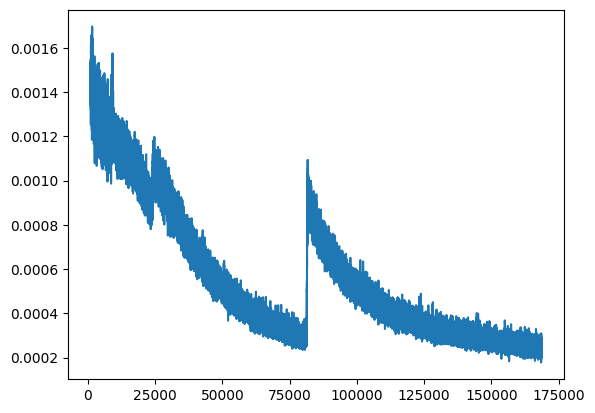

In [56]:
smooth = 1
x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[1000:], y[1000:])


In [7]:
def game_sim():
    snake = [(14, 14)]
    dataset = []
    moves = 0
    while True:
        dataset.append(snake.copy())
        while True:
            apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
            if apple not in snake:
                break
        pathington = BFS(snake[0], apple, snake, 1)
        if len(pathington) == 0:
            return dataset, moves, len(snake)
        path = pathington[0]
        moves += len(path)
        path = path + snake
        snake.append((0, 0))
        for i, piece in enumerate(snake):
            snake[i] = path[i]

In [8]:
def get_neighbors(p, snake, distance):
    reduced = snake.copy()
    for i in range(distance):
        if len(reduced) > 0:
            reduced.remove(reduced[len(reduced) - 1])
    if p[0] + 1 < board_size and (p[0] + 1, p[1]) not in reduced:
        top = (p[0] + 1, p[1])
    else:
        top = None
    if p[0] - 1 > -1 and (p[0] - 1, p[1]) not in reduced:
        bottom = (p[0] - 1, p[1])
    else:
        bottom = None
    if p[1] + 1 < board_size and (p[0], p[1] + 1) not in reduced:
        right = (p[0], p[1] + 1)
    else:
        right = None
    if p[1] - 1 > -1 and (p[0], p[1] - 1) not in reduced:
        left = (p[0], p[1] - 1)
    else:
        left = None
    return top, right, bottom, left

In [9]:
class Node:
    def __init__(self, value, depth, path, h): # depth is inherently g score
        self.value = value
        self.path = path + [value]
        self.depth = depth
        self.h = h
    def __eq__(self, other):
        if self.value == other.value and self.depth == other.depth:
            return True
        else:
            return False

In [10]:
def BFS(start, end, snake, n):
    paths = []
    tree = [Node(start, 0, [], euclidian(start, end))]
    while len(tree) != 0:
        min_val = 1000000
        min_node = None
        for i in tree:
            if i.depth + i.h < min_val:
                min_val = i.depth + i.h
                min_node = i
        current = min_node
        if current.value == end:
            paths.append(list(reversed(current.path)))
        if len(paths) == n:
            return paths
        neighbors = get_neighbors(current.value, snake, current.depth)
        for neighbor in neighbors:
            if neighbor is not None:
                node = Node(neighbor, current.depth + 1, current.path, euclidian(neighbor, end))
                if node not in tree and neighbor not in current.path:
                    tree.append(node)
        tree.remove(current)
    return paths

In [11]:
def euclidian(a, b):
    x = abs(a[0] - b[0])
    y = abs(a[1] - b[1])
    return np.sqrt(x**2 + y**2)